In [88]:
import pandas as pd
import numpy as np
import scipy

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [89]:
train = pd.read_csv('../data/CAX_MortgageModeling_Train.csv')

In [90]:
train.head(3)

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT
0,CAX_Train_1,1,900000,5429,61.98,65.00,71.63,360,1040000.0,4.0,Refinance,Monthly,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,FUNDED
1,CAX_Train_2,2,386000,2179,35.22,74.29,40.65,360,390000.0,4.5,Refinance,Monthly,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,FUNDED
2,CAX_Train_3,3,531000,2152,30.97,80.00,35.41,360,424800.0,3.5,Purchase,Monthly,Single Detached,6,M1N,35-39,Female,87000,2,72,709,FUNDED


In [91]:
train.RESULT = train.RESULT.apply(lambda x: 1 if x == 'FUNDED' else 0)

In [92]:
train.RESULT = train.RESULT.apply(lambda x: 1-x)

In [93]:
target = train.RESULT

In [94]:
test = pd.read_csv('../data/CAX_MortgageModeling_Test.csv')

In [95]:
test.head(3)

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT
0,CAX_Test_1,45643,430000,1861,34.51,75.00,35.60,360,322500.0,4.25,Refinance,Monthly,High Rise,24,M9B,45-49,Male,76000,8,23,834,NaN
1,CAX_Test_2,45644,676000,1032,37.18,55.51,37.50,360,375000.0,5.00,Purchase,Bi-Weekly,Semi-Detached,12,M3N,55-59,Female,75000,2,56,804,NaN
2,CAX_Test_3,45645,418000,949,23.30,79.90,32.88,360,334000.0,4.75,Refinance,Bi-Weekly,Single Detached,60,K2H,30-34,Male,70000,8,72,730,NaN


In [96]:
test_id = test.Unique_ID

In [97]:
print (train.shape, test.shape)

(45642, 22) (15214, 22)


In [98]:
train_len = train.shape[0]
traincols = list(train.columns[2:-1])

In [99]:
traincols

['PROPERTY VALUE',
 'MORTGAGE PAYMENT',
 'GDS',
 'LTV',
 'TDS',
 'AMORTIZATION',
 'MORTGAGE AMOUNT',
 'RATE',
 'MORTGAGE PURPOSE',
 'PAYMENT FREQUENCY',
 'PROPERTY TYPE',
 'TERM',
 'FSA',
 'AGE RANGE',
 'GENDER',
 'INCOME',
 'INCOME TYPE',
 'NAICS CODE',
 'CREDIT SCORE']

In [100]:
data = pd.concat([train[['Unique_ID'] + traincols+['RESULT']],test[['Unique_ID']+traincols+['RESULT']]],axis=0)

In [101]:
data['GDS'] = np.abs(data['GDS'])
data['GDS'] = np.clip(data.GDS,0,100)

In [102]:
data['TDS'] = np.abs(data['TDS'])
data['TDS'] = np.clip(data.TDS,0,100)

In [103]:
data['GDS'] = data['GDS']/100
data['LTV'] = data['LTV']/100
data['TDS'] = data['TDS']/100
data['RATE'] = data['RATE']/100

In [104]:
data['ANNUALIZED HOUSING EXPENSE'] = data['GDS'] * data['INCOME']
data['MORTGAGE RATIO'] = data['MORTGAGE AMOUNT']/data['PROPERTY VALUE']
data['OTHER EXPENSE'] = data['INCOME'] * data['TDS'] - data['ANNUALIZED HOUSING EXPENSE']
data['RENT INCOME'] = data.apply(lambda x: np.abs(x['OTHER EXPENSE']) if x.GDS > x.TDS else 0, axis=1)
data['OTHER EXPENSE'] = np.clip(data['OTHER EXPENSE'],0,data['OTHER EXPENSE'].max())

In [105]:
def f(x):
    if x['PAYMENT FREQUENCY'] in ['Bi-Weekly','Bi-Weekly Accelerated','Semi-Monthly'] :
        return 2
    elif x['PAYMENT FREQUENCY'] in ['Weekly','Weekly Accelerated']:
        return 4
    else:
        return x['PAYMENT FREQUENCY IN MONTHS']
data['PAYMENT FREQUENCY IN MONTHS'] = 1
data['PAYMENT FREQUENCY IN MONTHS'] = data.apply(lambda x: f(x), axis=1)

In [106]:
data['MORTGAGE PAYMENT'] = data['PAYMENT FREQUENCY IN MONTHS'] * data['MORTGAGE PAYMENT']

In [107]:
data['ACTUAL MORTGAGE PAYMENT'] = data.apply(lambda x: x['MORTGAGE AMOUNT'] * np.exp(x.RATE*x.AMORTIZATION*1.0/12), axis=1)
data['TOTAL INTEREST'] = data.apply(lambda x: x['ACTUAL MORTGAGE PAYMENT'] - x['MORTGAGE AMOUNT'], axis=1)

In [108]:
data['MORTGAGE AMOUNT PER INCOME'] = data['MORTGAGE AMOUNT']/data['INCOME']
data['MORTGAGE PAYMENT PER INCOME'] = data['MORTGAGE PAYMENT']*12/data['INCOME']
data['PROPERTY VALUE PER INCOME'] = data['PROPERTY VALUE']/data['INCOME']
data['TOTAL INTEREST PER INCOME'] = data['TOTAL INTEREST']/data['INCOME']
data['OTHER EXPENSE PER INCOME'] = data['OTHER EXPENSE']/data['INCOME']
data['ANNUALIZED HOUSING EXPENSE PER INCOME'] = data['ANNUALIZED HOUSING EXPENSE']/data['INCOME']

In [109]:
data['ACTUAL MORTGAGE PAYMENT BY MORTGAGE'] = data['ACTUAL MORTGAGE PAYMENT']/data['MORTGAGE AMOUNT']

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
data.head(10)

,Unique_ID,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,ANNUALIZED HOUSING EXPENSE,MORTGAGE RATIO,OTHER EXPENSE,RENT INCOME,PAYMENT FREQUENCY IN MONTHS,ACTUAL MORTGAGE PAYMENT,TOTAL INTEREST,MORTGAGE AMOUNT PER INCOME,MORTGAGE PAYMENT PER INCOME,PROPERTY VALUE PER INCOME,TOTAL INTEREST PER INCOME,OTHER EXPENSE PER INCOME,ANNUALIZED HOUSING EXPENSE PER INCOME,ACTUAL MORTGAGE PAYMENT BY MORTGAGE
0,CAX_Train_1,900000,5429,0.6198,0.65000,0.7163,360,1040000.0,0.040,Refinance,Monthly,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,0.0,66938.4,1.155556,10422.0,0.0,1,3.452922e+06,2.412922e+06,9.629630,0.603222,8.333333,22.341867,0.0965,0.6198,3.320117
1,CAX_Train_2,386000,2179,0.3522,0.74290,0.4065,360,390000.0,0.045,Refinance,Monthly,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,0.0,27471.6,1.010363,4235.4,0.0,1,1.504396e+06,1.114396e+06,5.000000,0.335231,4.948718,14.287128,0.0543,0.3522,3.857426
2,CAX_Train_3,531000,2152,0.3097,0.80000,0.3541,360,424800.0,0.035,Purchase,Monthly,Single Detached,6,M1N,35-39,Female,87000,2,72,709,0.0,26943.9,0.800000,3862.8,0.0,1,1.213930e+06,7.891302e+05,4.882759,0.296828,6.103448,9.070462,0.0444,0.3097,2.857651
3,CAX_Train_4,1200000,5410,0.1904,0.75000,0.3414,360,960000.0,0.055,Purchase,Monthly,Single Detached,12,M2M,45-49,Male,300000,8,54,761,0.0,57120.0,0.800000,45300.0,0.0,1,4.998701e+06,4.038701e+06,3.200000,0.216400,4.000000,13.462335,0.1510,0.1904,5.206980
4,CAX_Train_5,350000,3342,0.2959,0.80000,0.3485,360,592000.0,0.050,Refinance,Monthly,Single Detached,12,L7G,50-54,Male,147000,8,62,762,0.0,43497.3,1.691429,7732.2,0.0,1,2.653160e+06,2.061160e+06,4.027211,0.272816,2.380952,14.021496,0.0526,0.2959,4.481689
5,CAX_Train_6,420000,2179,0.2616,0.69050,0.2616,240,290000.0,0.055,Refinance,Monthly,Single Detached,24,M1M,40-44,Female,106000,2,53,570,0.0,27729.6,0.690476,0.0,0.0,1,8.712081e+05,5.812081e+05,2.735849,0.246679,3.962264,5.483096,0.0000,0.2616,3.004166
6,CAX_Train_7,1600000,5275,0.3212,0.69230,0.3390,360,900000.0,0.040,Refinance,Monthly,Single Detached,12,L7B,55-59,Female,185000,8,56,812,0.0,59422.0,0.562500,3293.0,0.0,1,2.988105e+06,2.088105e+06,4.864865,0.342162,8.648649,11.287055,0.0178,0.3212,3.320117
7,CAX_Train_8,1500000,4383,0.3568,0.55170,0.3781,360,644000.0,0.040,Refinance,Monthly,Single Detached,12,L3P,45-49,Male,160000,8,48-49,683,0.0,57088.0,0.429333,3408.0,0.0,1,2.138155e+06,1.494155e+06,4.025000,0.328725,9.375000,9.338471,0.0213,0.3568,3.320117
8,CAX_Train_9,790000,3092,0.3529,0.78481,0.3540,360,620000.0,0.035,Refinance,Monthly,Single Detached,60,M4C,45-49,Female,89000,2,61,684,1.0,31408.1,0.784810,97.9,0.0,1,1.771744e+06,1.151744e+06,6.966292,0.416899,8.876404,12.940940,0.0011,0.3529,2.857651
9,CAX_Train_10,650000,1839,0.3878,0.41850,0.3898,360,272000.0,0.055,Purchase,Monthly,Single Detached,12,L4W,40-44,Male,60000,2,56,716,0.0,23268.0,0.418462,120.0,0.0,1,1.416299e+06,1.144299e+06,4.533333,0.367800,10.833333,19.071642,0.0020,0.3878,5.206980


In [112]:
cnt_cols = []
cat_cols = []
for col in data.columns:
    if data[col].nunique() > 50 and data[col].dtype != object:
        cnt_cols.append(col)
    elif col != 'RESULT':
        cat_cols.append(col)


In [113]:
for col in cnt_cols:
    print (data[col].describe())

count    6.085600e+04
mean     5.817193e+05
std      4.331300e+05
min      1.400000e+04
25%      3.390000e+05
50%      4.750000e+05
75%      6.830000e+05
max      1.800000e+07
Name: PROPERTY VALUE, dtype: float64
count    60856.000000
mean      2454.518306
std       1656.003911
min        163.000000
25%       1486.000000
50%       2087.000000
75%       2903.000000
max      46479.000000
Name: MORTGAGE PAYMENT, dtype: float64
count    60856.000000
mean         0.278081
std          0.137138
min          0.000000
25%          0.198800
50%          0.292400
75%          0.359300
max          1.000000
Name: GDS, dtype: float64
count    60856.000000
mean         0.706617
std          0.115700
min          0.066670
25%          0.650000
50%          0.750000
75%          0.800000
max          0.950000
Name: LTV, dtype: float64
count    60856.000000
mean         0.380273
std          0.110454
min          0.000000
25%          0.328600
50%          0.383150
75%          0.421900
max          1

In [114]:
data.groupby(['MORTGAGE PURPOSE','PROPERTY TYPE'])['RESULT'].value_counts(normalize=True)

MORTGAGE PURPOSE  PROPERTY TYPE          RESULT
Purchase          Duplex                 0.0       0.739884
                                         1.0       0.260116
                  Fourplex               0.0       0.780488
                                         1.0       0.219512
                  High Rise              0.0       0.840486
                                         1.0       0.159514
                  Semi-Detached          0.0       0.843659
                                         1.0       0.156341
                  Single Detached        0.0       0.820442
                                         1.0       0.179558
                  Townhouse Condominium  0.0       0.841685
                                         1.0       0.158315
                  Townhouse Freehold     0.0       0.837321
                                         1.0       0.162679
                  Triplex                0.0       0.703125
                                         1.0       0

In [115]:
data.groupby(['NAICS CODE'])['RESULT'].value_counts(normalize=True)

NAICS CODE  RESULT
11          0.0       0.759868
            1.0       0.240132
22          0.0       0.841270
            1.0       0.158730
23          0.0       0.801453
            1.0       0.198547
31-33       0.0       0.814664
            1.0       0.185336
42          0.0       0.826531
            1.0       0.173469
44-45       0.0       0.808945
            1.0       0.191055
48-49       0.0       0.785477
            1.0       0.214523
51          0.0       0.820690
            1.0       0.179310
52          0.0       0.766145
            1.0       0.233855
53          0.0       0.808330
            1.0       0.191670
54          0.0       0.792903
            1.0       0.207097
55          1.0       0.544715
            0.0       0.455285
56          0.0       0.788439
            1.0       0.211561
61          0.0       0.799566
            1.0       0.200434
62          0.0       0.772392
            1.0       0.227608
71          0.0       0.785937
            1.0     

In [116]:
data.groupby(['INCOME TYPE'])['RESULT'].value_counts(normalize=True)

INCOME TYPE  RESULT
-1           0.0       0.845528
             1.0       0.154472
 1           0.0       0.865591
             1.0       0.134409
 2           0.0       0.784533
             1.0       0.215467
 3           0.0       0.831776
             1.0       0.168224
 4           0.0       0.810127
             1.0       0.189873
 5           0.0       0.754750
             1.0       0.245250
 6           0.0       0.822209
             1.0       0.177791
 7           0.0       0.806283
             1.0       0.193717
 8           0.0       0.790232
             1.0       0.209768
 9           0.0       0.815789
             1.0       0.184211
 10          0.0       0.857143
             1.0       0.142857
 11          0.0       0.842105
             1.0       0.157895
 12          0.0       0.884211
             1.0       0.115789
 13          1.0       1.000000
 14          1.0       0.666667
             0.0       0.333333
 15          0.0       0.702128
             1.0    

In [117]:
data.groupby(['GENDER','INCOME TYPE'])['RESULT'].value_counts(normalize=True)

GENDER   INCOME TYPE  RESULT
Female   -1           0.0       0.854167
                      1.0       0.145833
          1           0.0       0.845070
                      1.0       0.154930
          2           0.0       0.790471
                      1.0       0.209529
          3           0.0       0.854167
                      1.0       0.145833
          4           0.0       0.800000
                      1.0       0.200000
          5           0.0       0.721311
                      1.0       0.278689
          6           0.0       0.810931
                      1.0       0.189069
          7           0.0       0.861538
                      1.0       0.138462
          8           0.0       0.794454
                      1.0       0.205546
          9           0.0       0.833333
                      1.0       0.166667
          10          0.0       0.750000
                      1.0       0.250000
          11          0.0       0.909091
                      1.0   

In [118]:
data.groupby(['FSA','PROPERTY TYPE'])['RESULT'].value_counts(normalize=True)

FSA  PROPERTY TYPE          RESULT
A0A  Duplex                 0.0       1.000000
     Single Detached        0.0       0.746479
                            1.0       0.253521
A0V  Townhouse Condominium  1.0       1.000000
A1A  Duplex                 1.0       1.000000
     High Rise              1.0       0.666667
                            0.0       0.333333
     Single Detached        0.0       0.740741
                            1.0       0.259259
     Townhouse Condominium  0.0       1.000000
     Townhouse Freehold     0.0       0.666667
                            1.0       0.333333
A1B  Duplex                 0.0       1.000000
     High Rise              0.0       1.000000
     Semi-Detached          0.0       1.000000
     Single Detached        0.0       0.785714
                            1.0       0.214286
     Townhouse Condominium  0.0       1.000000
A1C  Semi-Detached          0.0       0.800000
                            1.0       0.200000
     Single Detached     

In [119]:
data.groupby(['GENDER','AGE RANGE','AMORTIZATION'])['RESULT'].value_counts(normalize=True)

GENDER   AGE RANGE    AMORTIZATION  RESULT
Female   25-29        300           0.0       0.722222
                                    1.0       0.277778
                      360           0.0       0.799202
                                    1.0       0.200798
         30-34        240           0.0       1.000000
                      300           0.0       0.698413
                                    1.0       0.301587
                      360           0.0       0.807867
                                    1.0       0.192133
                      420           1.0       1.000000
         35-39        240           0.0       1.000000
                      300           0.0       0.730337
                                    1.0       0.269663
                      360           0.0       0.796348
                                    1.0       0.203652
         40-44        180           0.0       1.000000
                      240           0.0       1.000000
                      

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


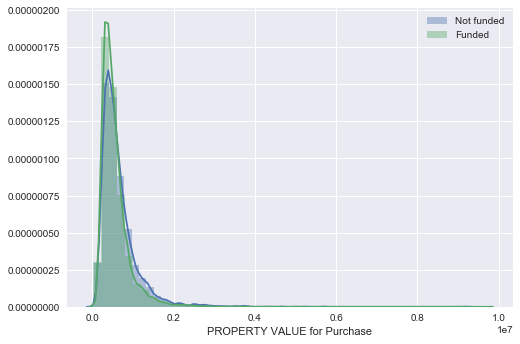

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


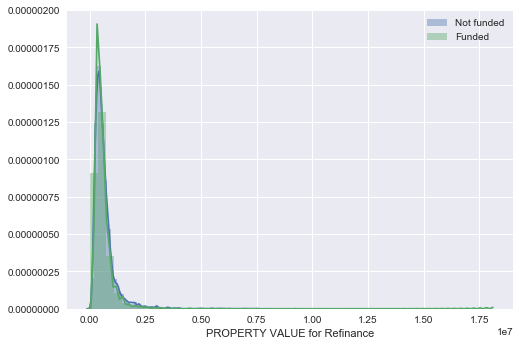

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


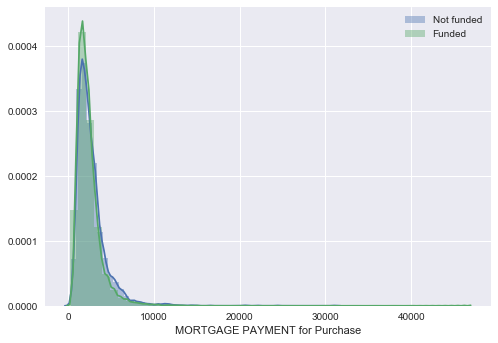

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


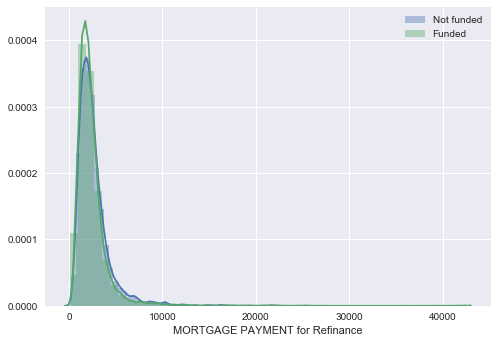

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


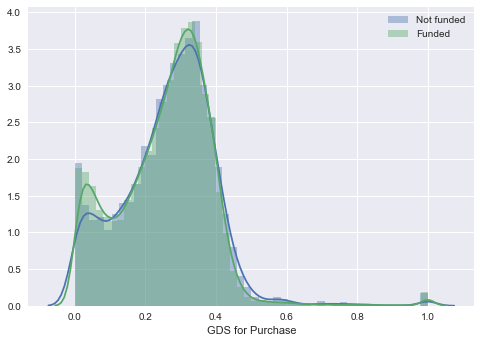

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


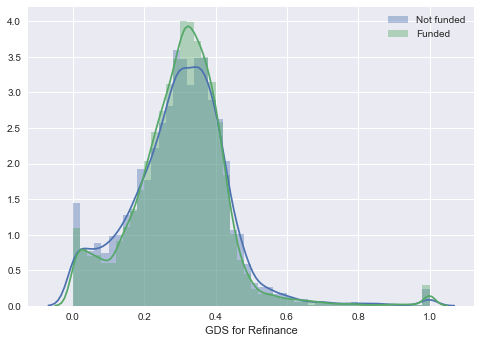

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


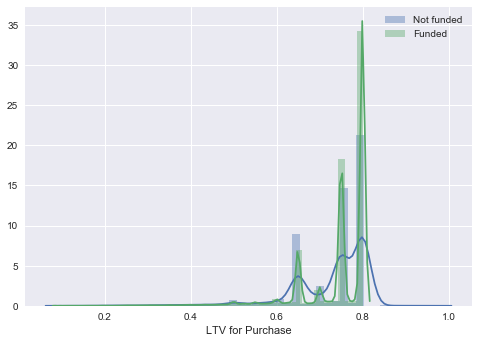

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


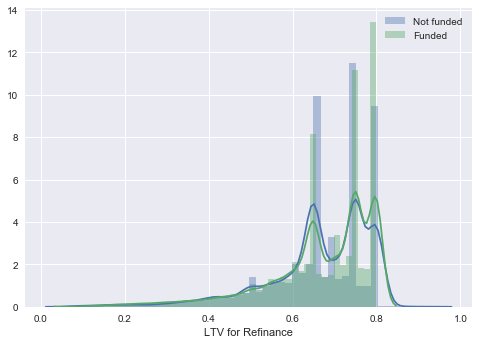

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


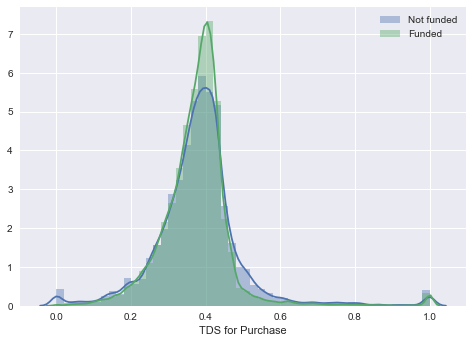

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


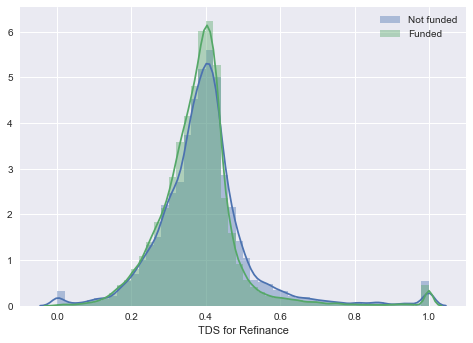

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


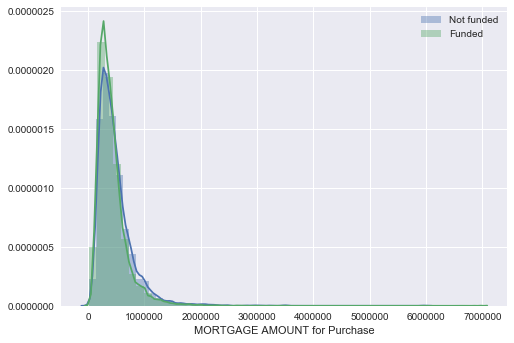

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


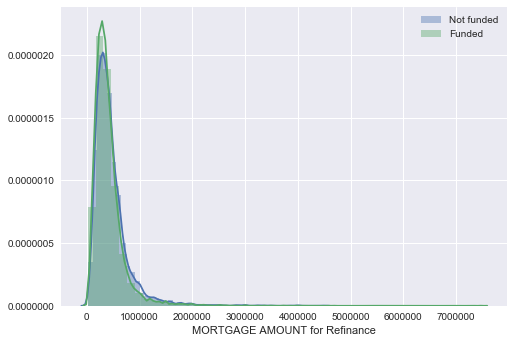

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


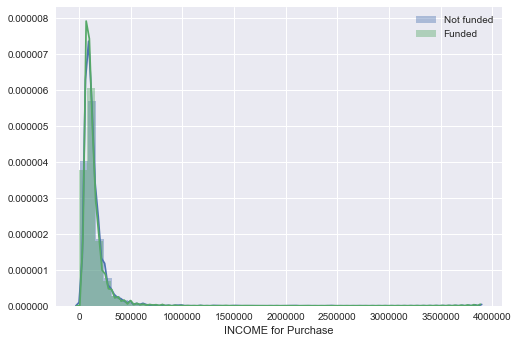

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


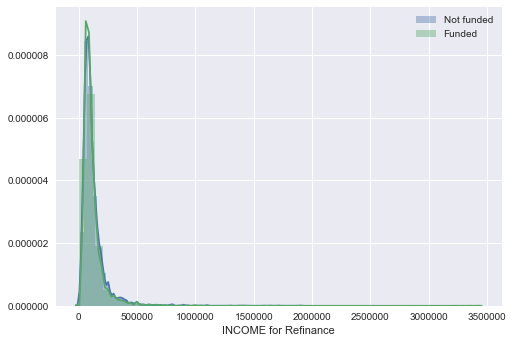

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


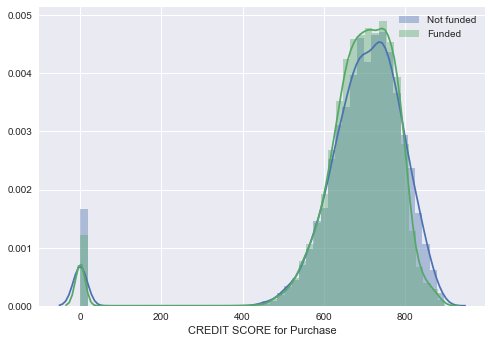

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


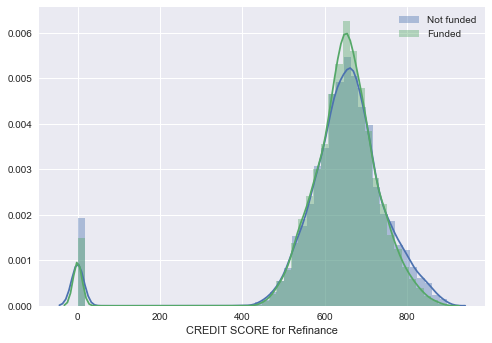

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


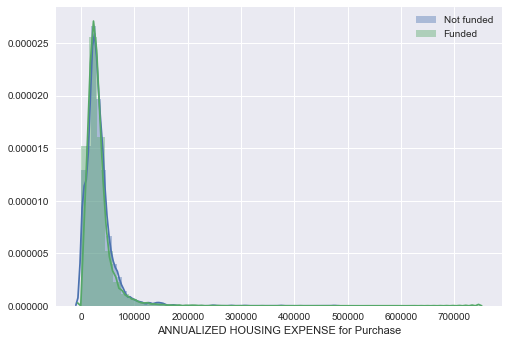

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


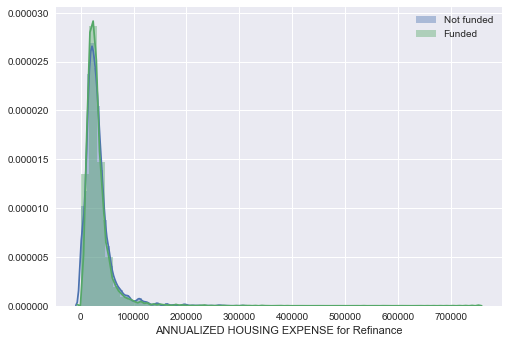

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


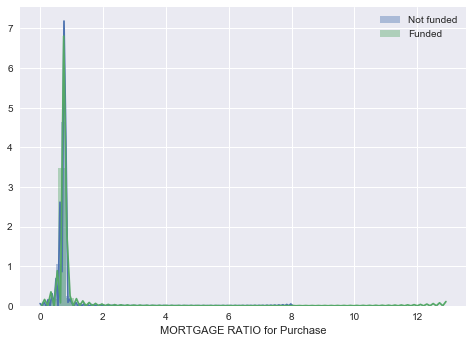

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


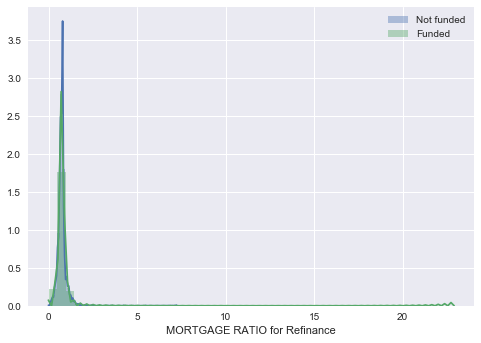

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


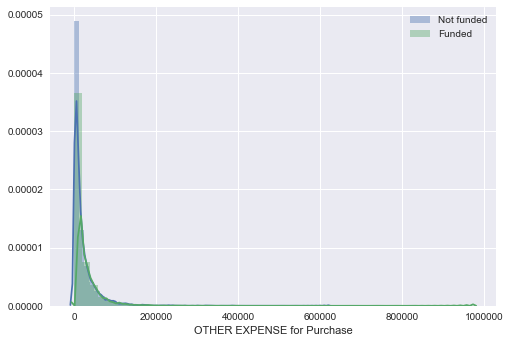

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


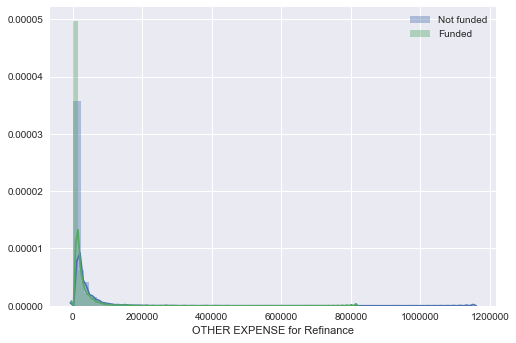

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


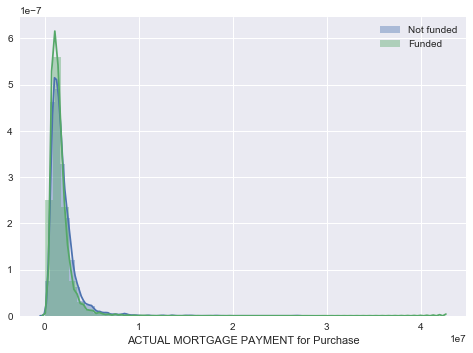

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


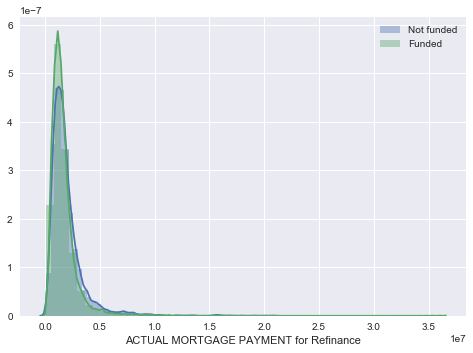

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


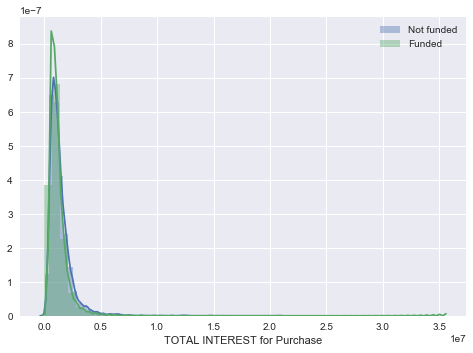

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


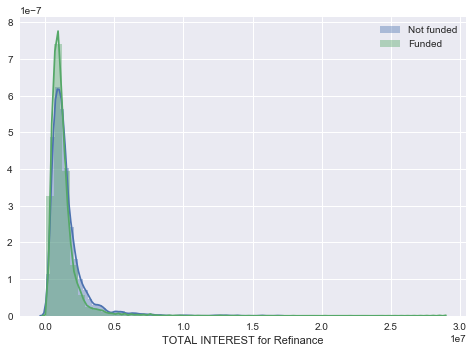

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


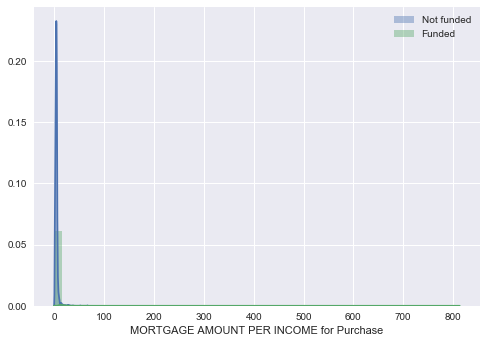

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


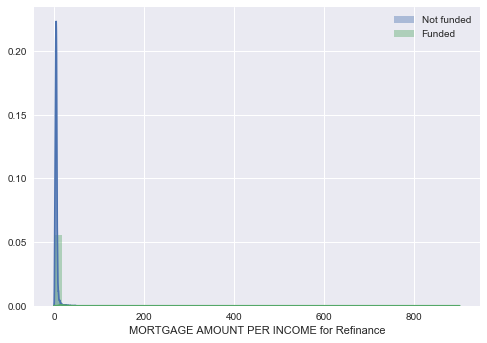

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


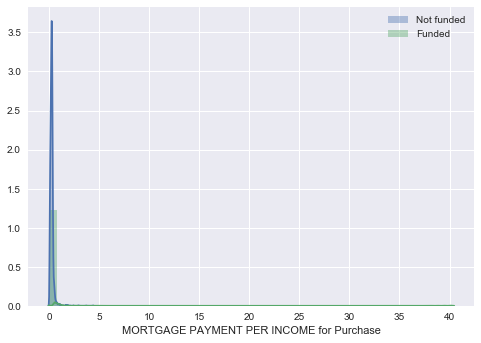

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


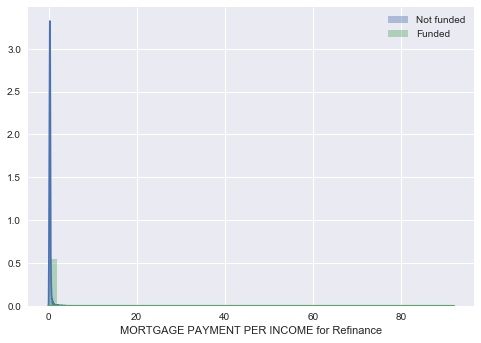

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


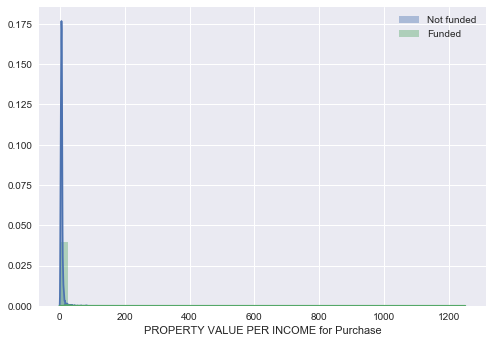

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


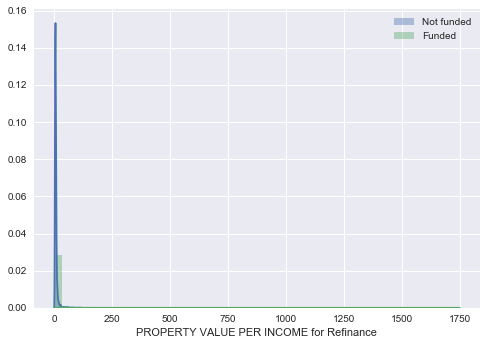

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


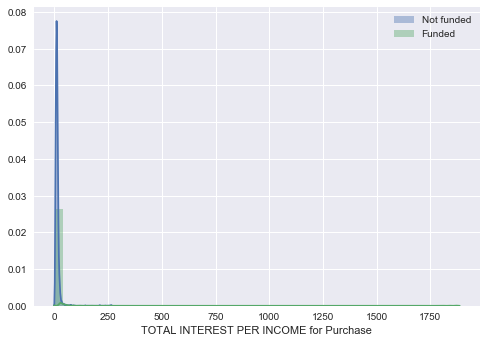

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


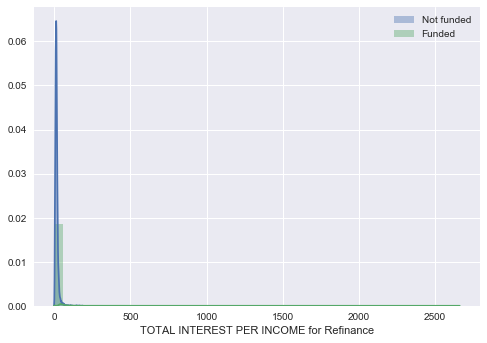

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


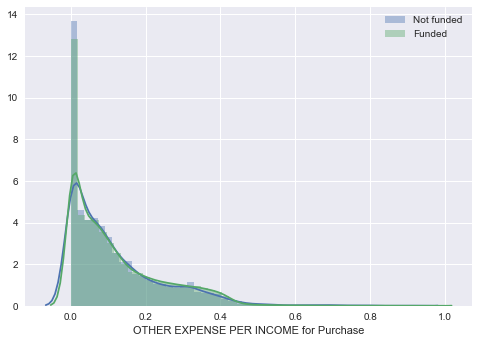

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


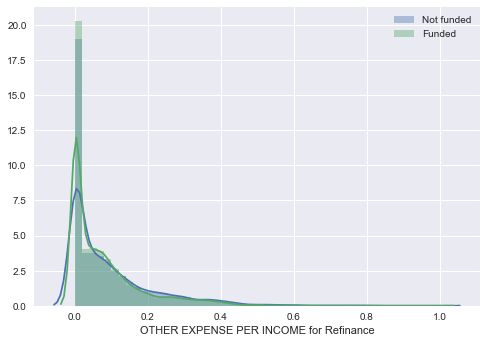

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


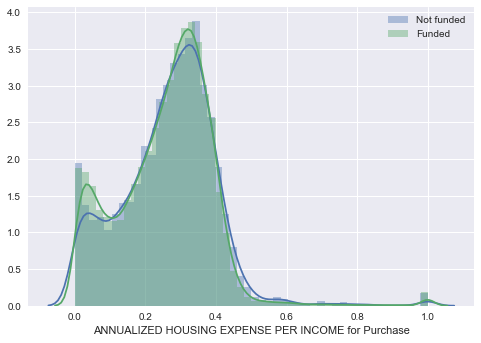

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


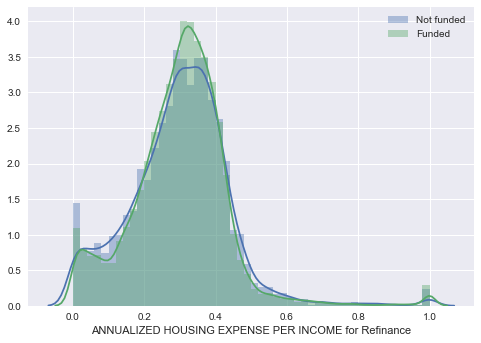

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


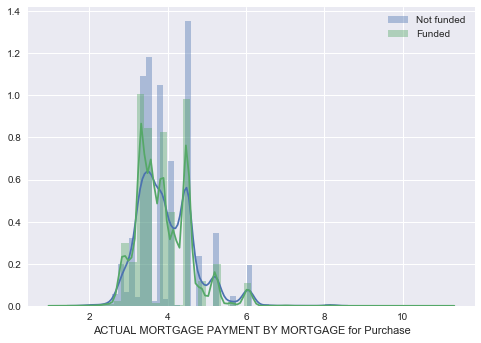

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


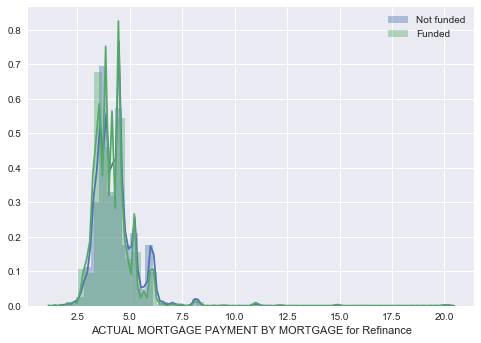

In [120]:
for col in cnt_cols:
    for prop_type in ['Purchase','Refinance']:
        df = data[data['MORTGAGE PURPOSE'] == prop_type]
        sns.distplot(df[df.RESULT == 1][col],kde=True,label='Not funded')
        sns.distplot(df[df.RESULT == 0][col],kde=True,label='Funded')
        plt.xlabel("{} for {}".format(col,prop_type))
        plt.legend()
        plt.show()

In [121]:
data2 = data.copy()

In [122]:
data.head(10)

,Unique_ID,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,ANNUALIZED HOUSING EXPENSE,MORTGAGE RATIO,OTHER EXPENSE,RENT INCOME,PAYMENT FREQUENCY IN MONTHS,ACTUAL MORTGAGE PAYMENT,TOTAL INTEREST,MORTGAGE AMOUNT PER INCOME,MORTGAGE PAYMENT PER INCOME,PROPERTY VALUE PER INCOME,TOTAL INTEREST PER INCOME,OTHER EXPENSE PER INCOME,ANNUALIZED HOUSING EXPENSE PER INCOME,ACTUAL MORTGAGE PAYMENT BY MORTGAGE
0,CAX_Train_1,900000,5429,0.6198,0.65000,0.7163,360,1040000.0,0.040,Refinance,Monthly,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,0.0,66938.4,1.155556,10422.0,0.0,1,3.452922e+06,2.412922e+06,9.629630,0.603222,8.333333,22.341867,0.0965,0.6198,3.320117
1,CAX_Train_2,386000,2179,0.3522,0.74290,0.4065,360,390000.0,0.045,Refinance,Monthly,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,0.0,27471.6,1.010363,4235.4,0.0,1,1.504396e+06,1.114396e+06,5.000000,0.335231,4.948718,14.287128,0.0543,0.3522,3.857426
2,CAX_Train_3,531000,2152,0.3097,0.80000,0.3541,360,424800.0,0.035,Purchase,Monthly,Single Detached,6,M1N,35-39,Female,87000,2,72,709,0.0,26943.9,0.800000,3862.8,0.0,1,1.213930e+06,7.891302e+05,4.882759,0.296828,6.103448,9.070462,0.0444,0.3097,2.857651
3,CAX_Train_4,1200000,5410,0.1904,0.75000,0.3414,360,960000.0,0.055,Purchase,Monthly,Single Detached,12,M2M,45-49,Male,300000,8,54,761,0.0,57120.0,0.800000,45300.0,0.0,1,4.998701e+06,4.038701e+06,3.200000,0.216400,4.000000,13.462335,0.1510,0.1904,5.206980
4,CAX_Train_5,350000,3342,0.2959,0.80000,0.3485,360,592000.0,0.050,Refinance,Monthly,Single Detached,12,L7G,50-54,Male,147000,8,62,762,0.0,43497.3,1.691429,7732.2,0.0,1,2.653160e+06,2.061160e+06,4.027211,0.272816,2.380952,14.021496,0.0526,0.2959,4.481689
5,CAX_Train_6,420000,2179,0.2616,0.69050,0.2616,240,290000.0,0.055,Refinance,Monthly,Single Detached,24,M1M,40-44,Female,106000,2,53,570,0.0,27729.6,0.690476,0.0,0.0,1,8.712081e+05,5.812081e+05,2.735849,0.246679,3.962264,5.483096,0.0000,0.2616,3.004166
6,CAX_Train_7,1600000,5275,0.3212,0.69230,0.3390,360,900000.0,0.040,Refinance,Monthly,Single Detached,12,L7B,55-59,Female,185000,8,56,812,0.0,59422.0,0.562500,3293.0,0.0,1,2.988105e+06,2.088105e+06,4.864865,0.342162,8.648649,11.287055,0.0178,0.3212,3.320117
7,CAX_Train_8,1500000,4383,0.3568,0.55170,0.3781,360,644000.0,0.040,Refinance,Monthly,Single Detached,12,L3P,45-49,Male,160000,8,48-49,683,0.0,57088.0,0.429333,3408.0,0.0,1,2.138155e+06,1.494155e+06,4.025000,0.328725,9.375000,9.338471,0.0213,0.3568,3.320117
8,CAX_Train_9,790000,3092,0.3529,0.78481,0.3540,360,620000.0,0.035,Refinance,Monthly,Single Detached,60,M4C,45-49,Female,89000,2,61,684,1.0,31408.1,0.784810,97.9,0.0,1,1.771744e+06,1.151744e+06,6.966292,0.416899,8.876404,12.940940,0.0011,0.3529,2.857651
9,CAX_Train_10,650000,1839,0.3878,0.41850,0.3898,360,272000.0,0.055,Purchase,Monthly,Single Detached,12,L4W,40-44,Male,60000,2,56,716,0.0,23268.0,0.418462,120.0,0.0,1,1.416299e+06,1.144299e+06,4.533333,0.367800,10.833333,19.071642,0.0020,0.3878,5.206980


In [123]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [124]:
#clf = StandardScaler()
#data[cnt_cols] = clf.fit_transform(data2[cnt_cols])

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


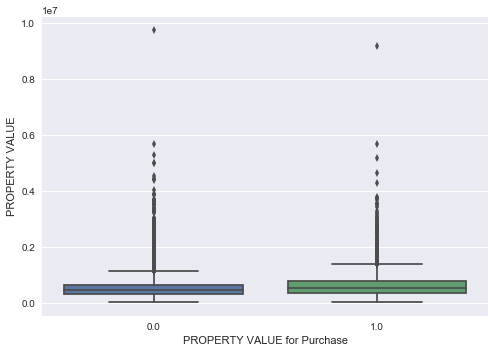

No handles with labels found to put in legend.


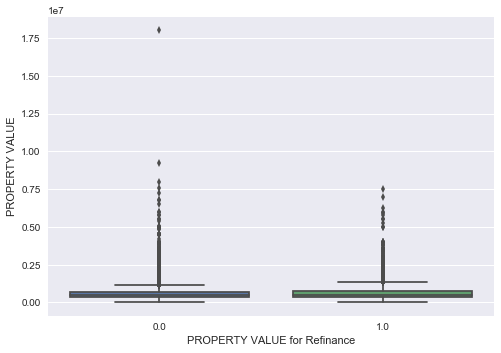

No handles with labels found to put in legend.


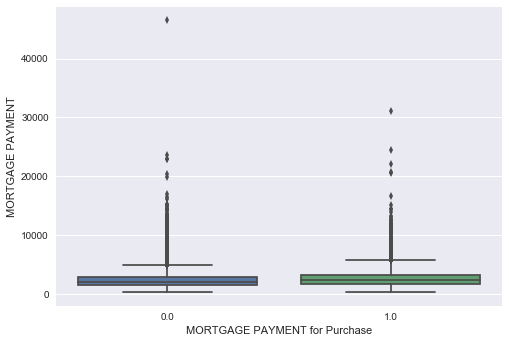

No handles with labels found to put in legend.


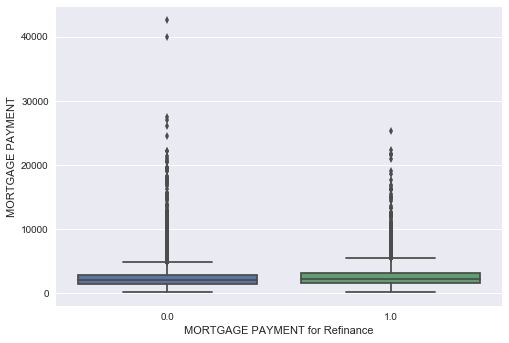

No handles with labels found to put in legend.


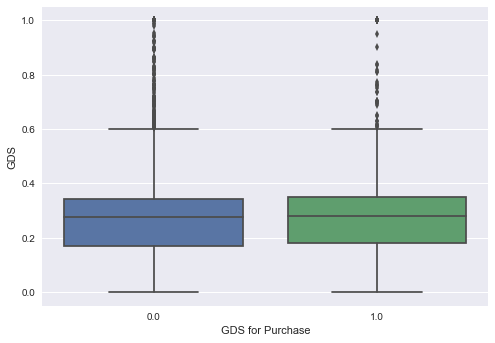

No handles with labels found to put in legend.


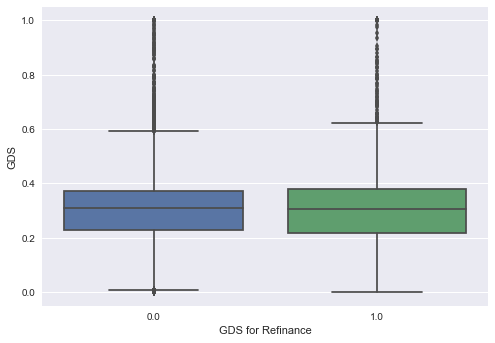

No handles with labels found to put in legend.


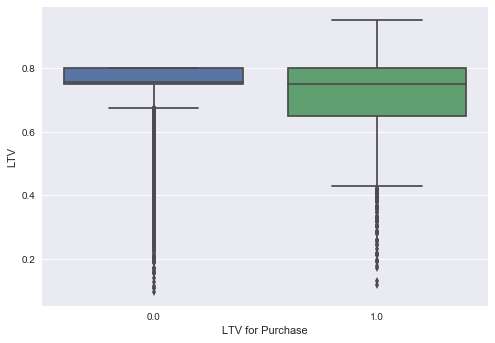

No handles with labels found to put in legend.


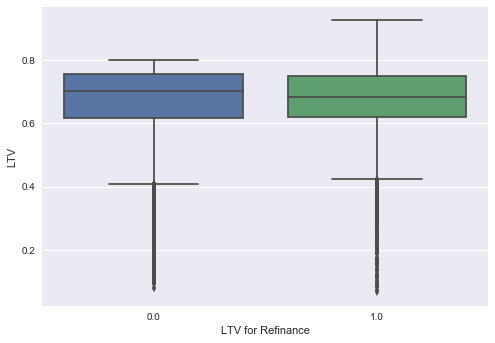

No handles with labels found to put in legend.


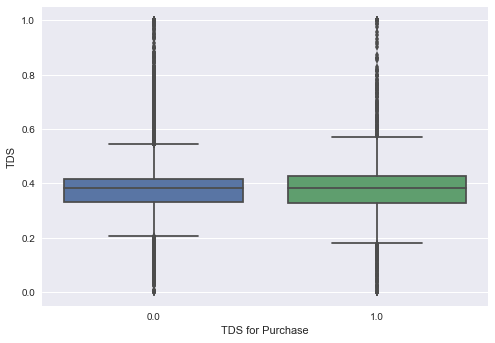

No handles with labels found to put in legend.


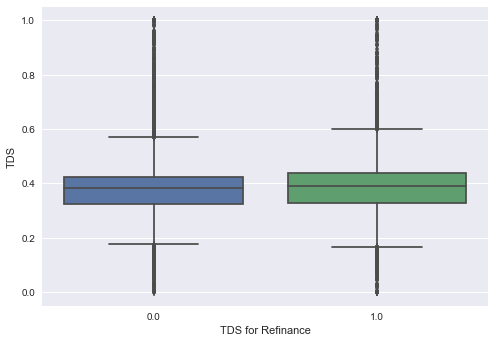

No handles with labels found to put in legend.


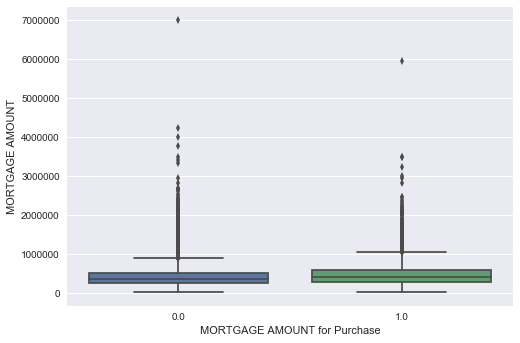

No handles with labels found to put in legend.


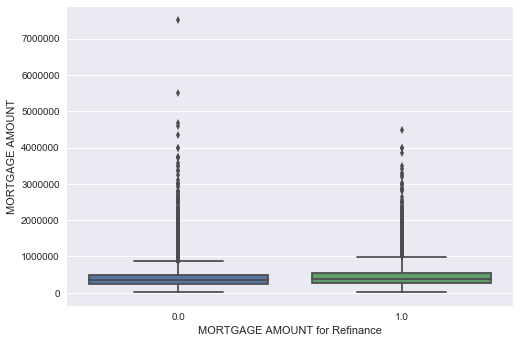

No handles with labels found to put in legend.


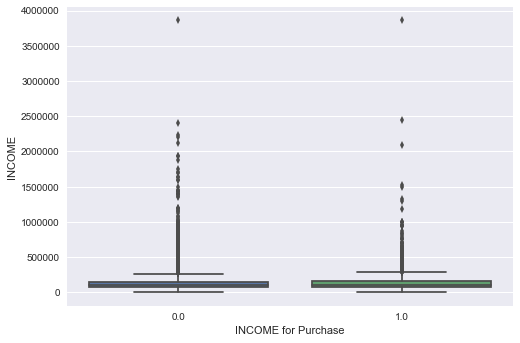

No handles with labels found to put in legend.


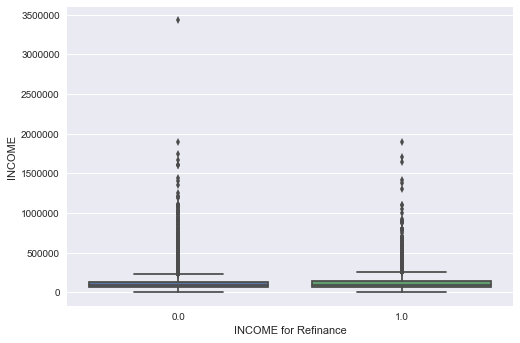

No handles with labels found to put in legend.


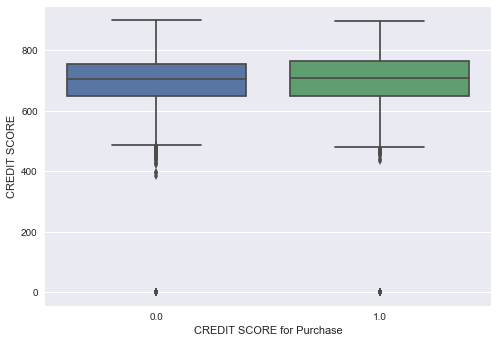

No handles with labels found to put in legend.


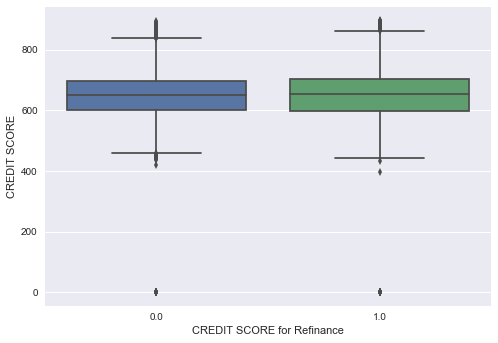

No handles with labels found to put in legend.


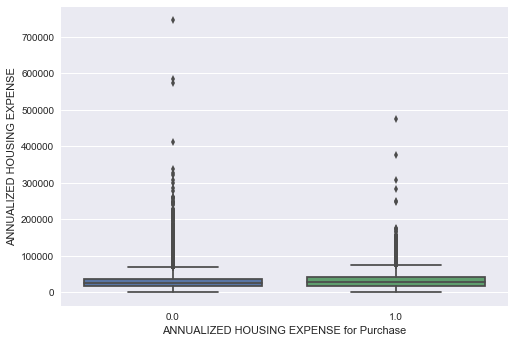

No handles with labels found to put in legend.


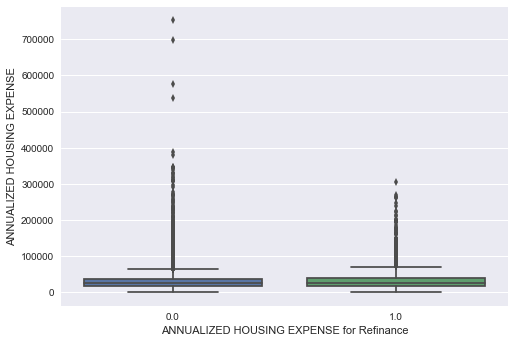

No handles with labels found to put in legend.


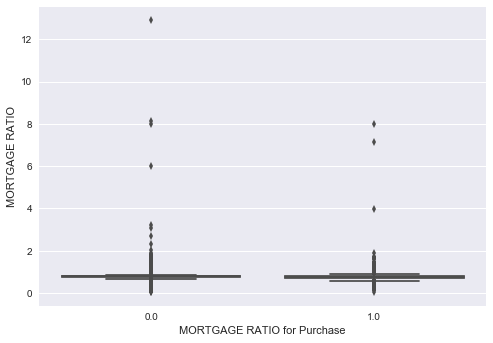

No handles with labels found to put in legend.


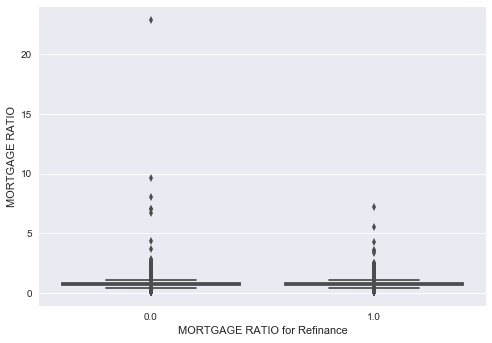

No handles with labels found to put in legend.


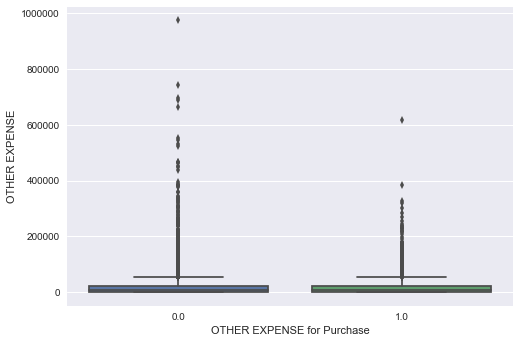

No handles with labels found to put in legend.


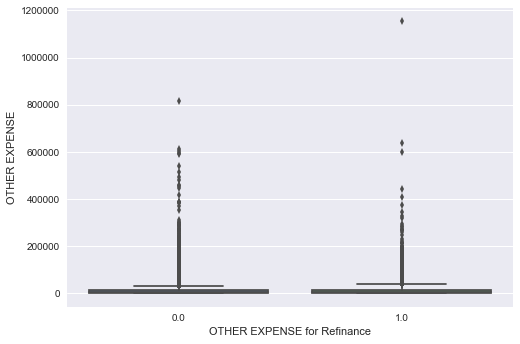

No handles with labels found to put in legend.


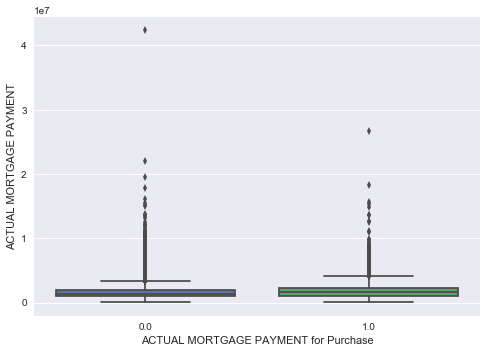

No handles with labels found to put in legend.


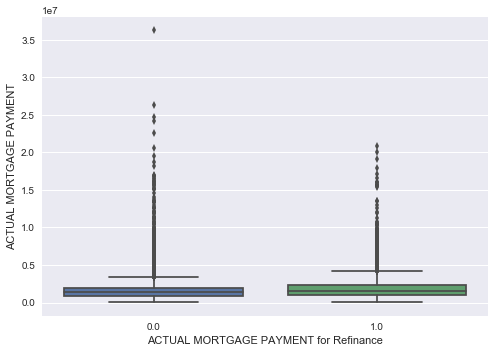

No handles with labels found to put in legend.


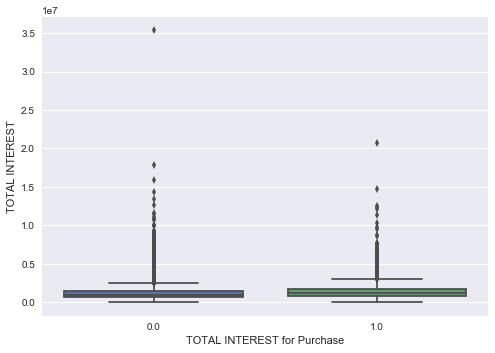

No handles with labels found to put in legend.


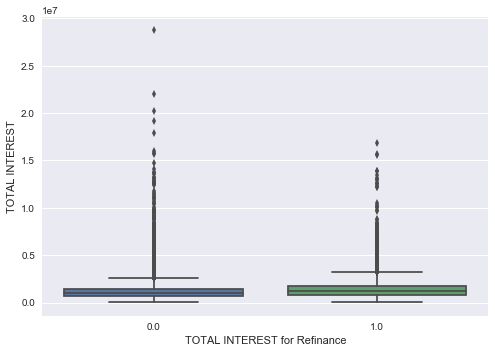

No handles with labels found to put in legend.


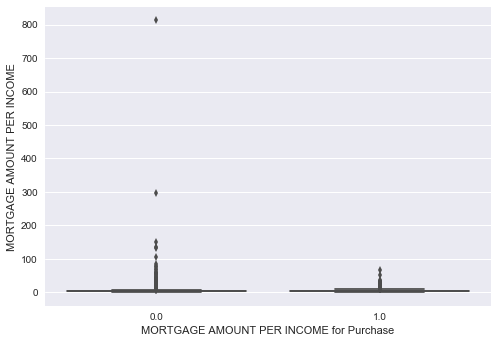

No handles with labels found to put in legend.


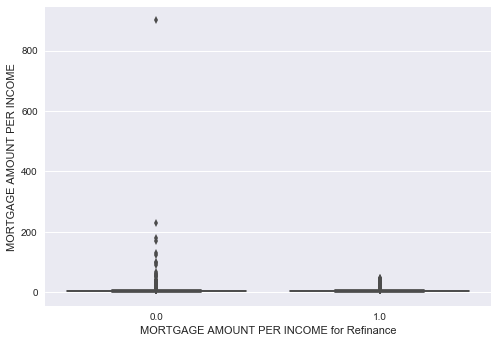

No handles with labels found to put in legend.


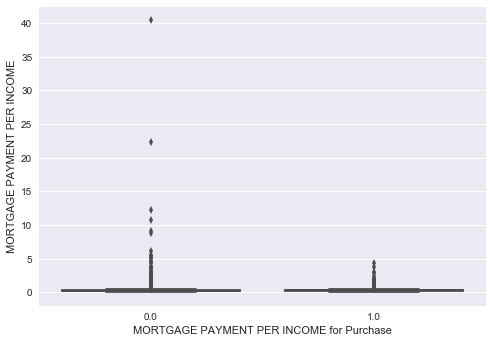

No handles with labels found to put in legend.


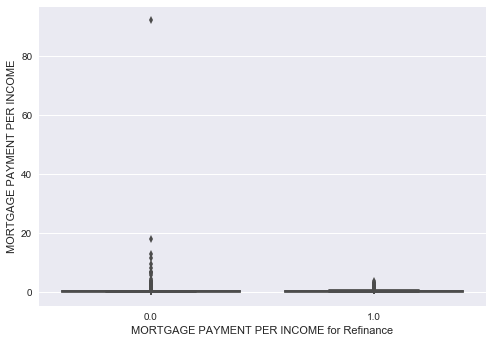

No handles with labels found to put in legend.


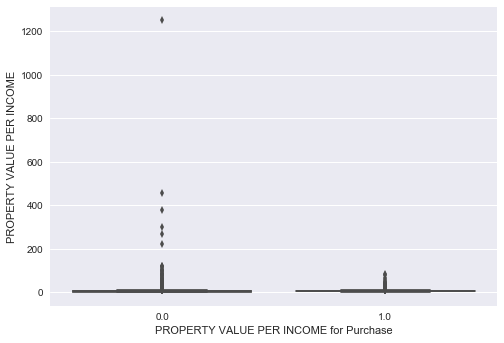

No handles with labels found to put in legend.


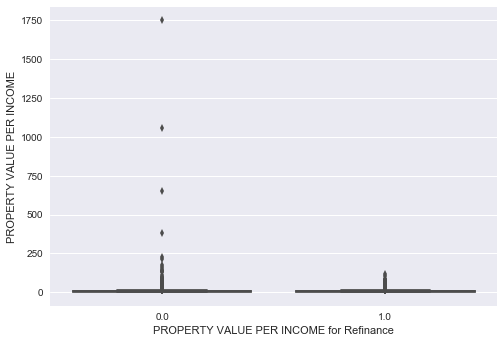

No handles with labels found to put in legend.


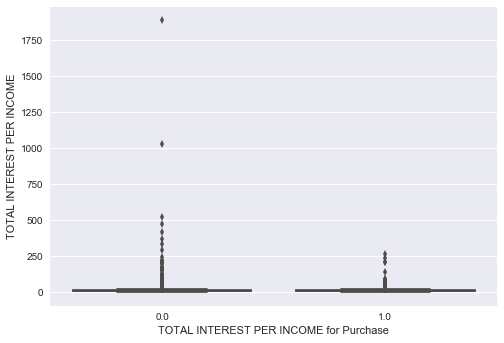

No handles with labels found to put in legend.


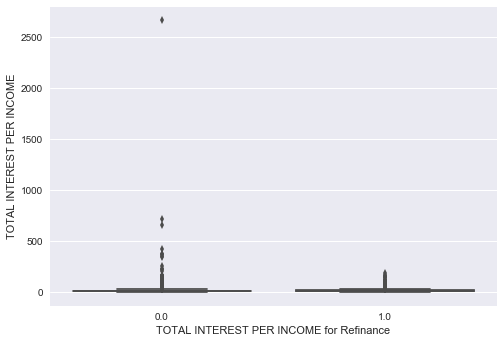

No handles with labels found to put in legend.


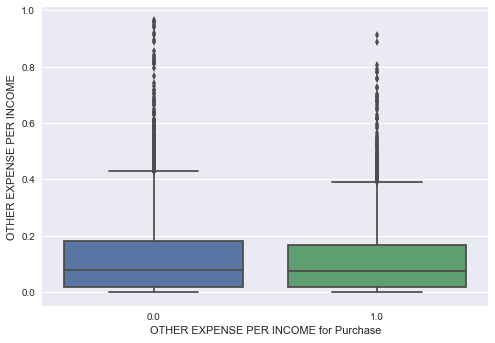

No handles with labels found to put in legend.


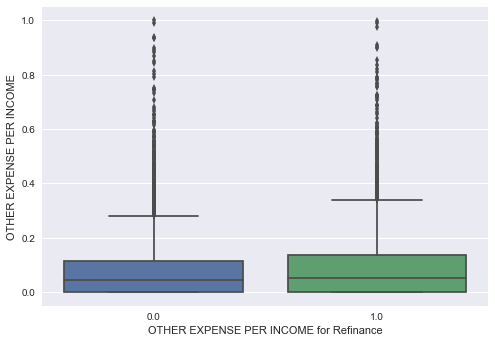

No handles with labels found to put in legend.


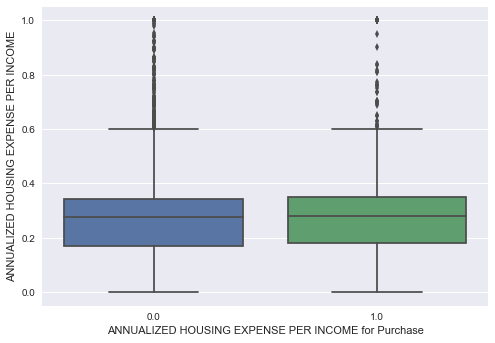

No handles with labels found to put in legend.


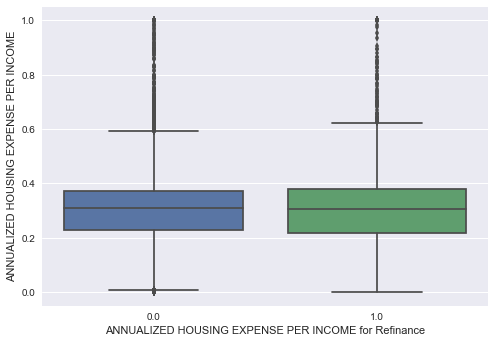

No handles with labels found to put in legend.


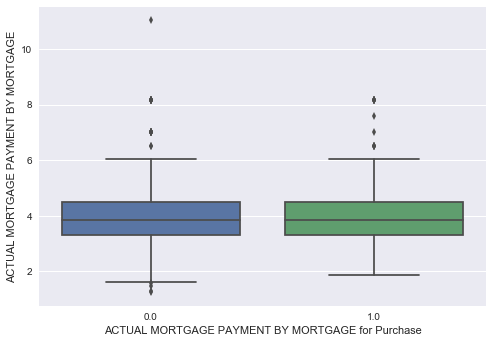

No handles with labels found to put in legend.


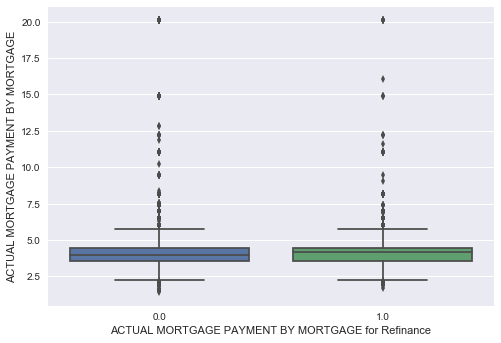

In [125]:
for col in cnt_cols:
    for prop_type in ['Purchase','Refinance']:
        df = data[data['MORTGAGE PURPOSE'] == prop_type]
        sns.boxplot(x='RESULT',y=col,data=df)
        plt.xlabel("{} for {}".format(col,prop_type))
        plt.legend()
        plt.show()

In [127]:
for cat_col in ['MORTGAGE PURPOSE','PROPERTY TYPE','AGE RANGE','GENDER','INCOME TYPE','NAICS CODE','FSA']:
    for cnt_col in cnt_cols:
        temp = data.groupby([cat_col])[cnt_col].agg(['mean','max','min','var']).reset_index()
        temp.columns = [cat_col,cnt_col+' ' + cat_col+' MEAN',cnt_col+' ' + cat_col+' MAX',cnt_col+' ' + cat_col+' MIN',cnt_col+' ' + cat_col+' VAR']
        data = pd.merge(data,temp,how='left')
        data[cnt_col+' ' + cat_col+' Z SCORE'] = data.apply(lambda x: (x[cnt_col]-x[cnt_col+' ' + cat_col+' MEAN'])/np.sqrt(x[cnt_col+' ' + cat_col+' VAR']), axis=1)
    print (cat_col)

MORTGAGE PURPOSE
PROPERTY TYPE
AGE RANGE
GENDER
INCOME TYPE
NAICS CODE


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


FSA


Target encoding script - https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

In [128]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [129]:
cat_comb_cols = []
for i in ['AGE RANGE','GENDER','FSA','NAICS CODE']:
    col = i + '_' + 'MORTGAGE PURPOSE' + '_' + 'PROPERTY TYPE'
    data[col] = data.apply(lambda x: str(x[i]) + '_' + str(x['MORTGAGE PURPOSE']) + '_' + str(x['PROPERTY TYPE']), axis=1)
    cat_comb_cols.append(col)

In [130]:
train = data.iloc[:train_len]
test = data.iloc[train_len:]

In [131]:
for col in cat_comb_cols:
    trn, sub = target_encode(train[col], 
                             test[col], 
                             target=train.RESULT, 
                             min_samples_leaf=5,
                             smoothing=10,
                             noise_level=0.01)
    data[col] = pd.concat([trn,sub],axis=0).values

In [179]:
#data = pd.get_dummies(data,columns=['AMORTIZATION','MORTGAGE PURPOSE','PAYMENT FREQUENCY','PROPERTY TYPE','TERM','AGE RANGE','GENDER','INCOME TYPE','NAICS CODE'])

In [133]:
data.to_csv('../data/data_full2.csv',index=False)

In [134]:
data.head(10)

Unique_ID  PROPERTY VALUE  MORTGAGE PAYMENT     GDS      LTV     TDS  \
0   CAX_Train_1          900000              5429  0.6198  0.65000  0.7163   
1   CAX_Train_2          386000              2179  0.3522  0.74290  0.4065   
2   CAX_Train_3          531000              2152  0.3097  0.80000  0.3541   
3   CAX_Train_4         1200000              5410  0.1904  0.75000  0.3414   
4   CAX_Train_5          350000              3342  0.2959  0.80000  0.3485   
5   CAX_Train_6          420000              2179  0.2616  0.69050  0.2616   
6   CAX_Train_7         1600000              5275  0.3212  0.69230  0.3390   
7   CAX_Train_8         1500000              4383  0.3568  0.55170  0.3781   
8   CAX_Train_9          790000              3092  0.3529  0.78481  0.3540   
9  CAX_Train_10          650000              1839  0.3878  0.41850  0.3898   

   AMORTIZATION  MORTGAGE AMOUNT   RATE MORTGAGE PURPOSE PAYMENT FREQUENCY  \
0           360        1040000.0  0.040        Refinance           Monthly   
1           360         390000.0  0.045        Refinance           Monthly   
2           360         424800.0  0.035         Purchase           Monthly   
3           360         960000.0  0.055         Purchase           Monthly   
4           360         592000.0  0.050        Refinance           Monthly   
5           240         290000.0  0.055        Refinance           Monthly   
6           360         900000.0  0.040        Refinance           Monthly   
7           360         644000.0  0.040        Refinance           Monthly   
8           360         620000.0  0.035        Refinance           Monthly   
9           360         272000.0  0.055         Purchase           Monthly   

     PROPERTY TYPE  TERM  FSA    AGE RANGE  GENDER  INCOME  INCOME TYPE  \
0  Single Detached    12  L4C     Under 25    Male  108000            8   
1  Single Detached    12  L9T  70 and over    Male   78000            2   
2  Single Detached     6  M1N        35-39  Female   87000            2   
3  Single Detached    12  M2M        45-49    Male  300000            8   
4  Single Detached    12  L7G        50-54    Male  147000            8   
5  Single Detached    24  M1M        40-44  Female  106000            2   
6  Single Detached    12  L7B        55-59  Female  185000            8   
7  Single Detached    12  L3P        45-49    Male  160000            8   
8  Single Detached    60  M4C        45-49  Female   89000            2   
9  Single Detached    12  L4W        40-44    Male   60000            2   

  NAICS CODE  CREDIT SCORE  RESULT  ANNUALIZED HOUSING EXPENSE  \
0      44-45           681     0.0                     66938.4   
1         56           710     0.0                     27471.6   
2         72           709     0.0                     26943.9   
3         54           761     0.0                     57120.0   
4         62           762     0.0                     43497.3   
5         53           570     0.0                     27729.6   
6         56           812     0.0                     59422.0   
7      48-49           683     0.0                     57088.0   
8         61           684     1.0                     31408.1   
9         56           716     0.0                     23268.0   

   MORTGAGE RATIO  OTHER EXPENSE  RENT INCOME  PAYMENT FREQUENCY IN MONTHS  \
0        1.155556        10422.0          0.0                            1   
1        1.010363         4235.4          0.0                            1   
2        0.800000         3862.8          0.0                            1   
3        0.800000        45300.0          0.0                            1   
4        1.691429         7732.2          0.0                            1   
5        0.690476            0.0          0.0                            1   
6        0.562500         3293.0          0.0                            1   
7        0.429333         3408.0          0.0                            1   
8        0.784810           97.9 

In [136]:
train = data.iloc[:train_len]
test = data.iloc[train_len:]

In [137]:
cols_to_remove = []
for col in data.columns:
    if col != 'RESULT':
        if train[col].nunique() == 1 or train[col].nunique() == 1:
            print (col)
            cols_to_remove.append(col)

GDS MORTGAGE PURPOSE MAX
GDS MORTGAGE PURPOSE MIN
TDS MORTGAGE PURPOSE MAX
TDS MORTGAGE PURPOSE MIN
INCOME MORTGAGE PURPOSE MIN
CREDIT SCORE MORTGAGE PURPOSE MAX
CREDIT SCORE MORTGAGE PURPOSE MIN
ANNUALIZED HOUSING EXPENSE MORTGAGE PURPOSE MIN
OTHER EXPENSE MORTGAGE PURPOSE MIN
OTHER EXPENSE PER INCOME MORTGAGE PURPOSE MIN
ANNUALIZED HOUSING EXPENSE PER INCOME MORTGAGE PURPOSE MAX
ANNUALIZED HOUSING EXPENSE PER INCOME MORTGAGE PURPOSE MIN
GDS PROPERTY TYPE MIN
CREDIT SCORE PROPERTY TYPE MIN
ANNUALIZED HOUSING EXPENSE PROPERTY TYPE MIN
OTHER EXPENSE PROPERTY TYPE MIN
OTHER EXPENSE PER INCOME PROPERTY TYPE MIN
ANNUALIZED HOUSING EXPENSE PER INCOME PROPERTY TYPE MIN
GDS AGE RANGE MAX
GDS AGE RANGE MIN
TDS AGE RANGE MAX
CREDIT SCORE AGE RANGE MIN
ANNUALIZED HOUSING EXPENSE AGE RANGE MIN
OTHER EXPENSE AGE RANGE MIN
OTHER EXPENSE PER INCOME AGE RANGE MIN
ANNUALIZED HOUSING EXPENSE PER INCOME AGE RANGE MAX
ANNUALIZED HOUSING EXPENSE PER INCOME AGE RANGE MIN
GDS GENDER MAX
GDS GENDER MIN
TDS G

In [152]:
cnt_cols = []
cat_cols = []
for col in data.columns:
    if col not in cols_to_remove:
        if data[col].nunique() > 5 and data[col].dtype != object:
            cnt_cols.append(col)
        elif col != 'RESULT':
            cat_cols.append(col)

532

In [139]:
'''
train_cols = []
for col in cnt_cols:

    d1 = train[train.RESULT == 1][col]
    d2 = train[train.RESULT == 0][col]
    p_value = scipy.stats.ttest_ind(d1,d2).pvalue

    if p_value < .01:
        print (col)
        train_cols.append(col)
'''

'\ntrain_cols = []\nfor col in cnt_cols:\n\n    d1 = train[train.RESULT == 1][col]\n    d2 = train[train.RESULT == 0][col]\n    p_value = scipy.stats.ttest_ind(d1,d2).pvalue\n\n    if p_value < .01:\n        print (col)\n        train_cols.append(col)\n'

In [140]:
print (train.shape, test.shape)

(45642, 739) (15214, 739)


In [141]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, BaseEnsemble, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import eli5
import shap
from sklearn import model_selection

In [142]:
kf = KFold(n_splits=5,random_state=123,shuffle=True)
train = train.sample(frac=1)
for train_index, test_index in kf.split(train):
    break

In [143]:
learning_rate = 0.1
feature_fraction = 1
num_boost_round = 1000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "is_unbalance": True
          }

In [144]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [47]:
'''
for train_index, test_index in kf.split(train):
    train_data = lgb.Dataset(train.iloc[train_index].values, label=target.iloc[train_index].values.astype(int), 
                         feature_name=list(train.columns))
    test_data = lgb.Dataset(train.iloc[test_index].values, label=target.iloc[test_index].values.astype(int), 
                        feature_name=list(train.columns), reference=train_data)
    lgb_model = lgb.train(params, train_data, 
                      num_boost_round=num_boost_round, 
                      valid_sets=(test_data,),  
                      verbose_eval=100)
'''

'\nfor train_index, test_index in kf.split(train):\n    train_data = lgb.Dataset(train.iloc[train_index].values, label=target.iloc[train_index].values.astype(int), \n                         feature_name=list(train.columns))\n    test_data = lgb.Dataset(train.iloc[test_index].values, label=target.iloc[test_index].values.astype(int), \n                        feature_name=list(train.columns), reference=train_data)\n    lgb_model = lgb.train(params, train_data, \n                      num_boost_round=num_boost_round, \n                      valid_sets=(test_data,),  \n                      verbose_eval=100)\n'

In [145]:
'''
train_data = lgb.Dataset(train.iloc[train_index][cnt_cols], label=train.RESULT.iloc[train_index].values.astype(int), 
                         feature_name=cnt_cols)
test_data = lgb.Dataset(train.iloc[test_index][cnt_cols], label=train.RESULT.iloc[test_index].values.astype(int), 
                    feature_name=cnt_cols, reference=train_data)
lgb_model = lgb.train(params, train_data, 
                  num_boost_round=10000, 
                  valid_sets=(test_data,),  
                  verbose_eval=100,feval=lgb_f1_score,early_stopping_rounds=200)
'''

'\ntrain_data = lgb.Dataset(train.iloc[train_index][cnt_cols], label=train.RESULT.iloc[train_index].values.astype(int), \n                         feature_name=cnt_cols)\ntest_data = lgb.Dataset(train.iloc[test_index][cnt_cols], label=train.RESULT.iloc[test_index].values.astype(int), \n                    feature_name=cnt_cols, reference=train_data)\nlgb_model = lgb.train(params, train_data, \n                  num_boost_round=10000, \n                  valid_sets=(test_data,),  \n                  verbose_eval=100,feval=lgb_f1_score,early_stopping_rounds=200)\n'

In [110]:
import scipy

In [154]:
for col in cnt_cols:
    if data[col].isnull().any() == True:
        print (col)
        cnt_cols.remove(col)

PROPERTY VALUE FSA VAR
MORTGAGE PAYMENT FSA VAR
GDS FSA VAR
LTV FSA VAR
TDS FSA VAR
MORTGAGE AMOUNT FSA VAR
INCOME FSA VAR
CREDIT SCORE FSA VAR
ANNUALIZED HOUSING EXPENSE FSA VAR
MORTGAGE RATIO FSA VAR
OTHER EXPENSE FSA VAR
ACTUAL MORTGAGE PAYMENT FSA VAR
TOTAL INTEREST FSA VAR
MORTGAGE AMOUNT PER INCOME FSA VAR
MORTGAGE PAYMENT PER INCOME FSA VAR
PROPERTY VALUE PER INCOME FSA VAR
TOTAL INTEREST PER INCOME FSA VAR
OTHER EXPENSE PER INCOME FSA VAR
ANNUALIZED HOUSING EXPENSE PER INCOME FSA VAR
ACTUAL MORTGAGE PAYMENT BY MORTGAGE FSA VAR


In [156]:
print (len(cnt_cols))

512


In [181]:
data.replace(np.nan,0,inplace=True)
data.replace(np.inf,0,inplace=True)

In [182]:
data3 = data.copy()
clf = StandardScaler()
data[cnt_cols] = clf.fit_transform(data[cnt_cols])

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [183]:
train = data.iloc[:train_len]
test = data.iloc[train_len:]

In [158]:
rf = RandomForestClassifier(n_estimators=500,class_weight={0:.2,1:.8})
rf.fit(train[cnt_cols].iloc[train_index], train.RESULT.iloc[train_index])
pred = rf.predict(train[cnt_cols].iloc[test_index])

In [159]:
print (accuracy_score(train.RESULT.iloc[test_index],pred))
print (confusion_matrix(train.RESULT.iloc[test_index],pred))
print (f1_score(train.RESULT.iloc[test_index],pred))

0.7935151714317011
[[7176   51]
 [1834   68]]
0.06729341909945571


In [184]:
train2 = pd.concat([train[train.RESULT == 0].sample(frac=.3),train[train.RESULT == 1]],axis=0).sample(frac=1)

In [185]:
for train_index2, test_index2 in kf.split(train2):
    break

In [177]:
cnt_cols = list(set(cnt_cols) - set(cat_comb_cols))

In [186]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(train2[cnt_cols].iloc[train_index2], train2.RESULT.iloc[train_index2])
pred = rf.predict(train2[cnt_cols].iloc[test_index2])

In [187]:
print (accuracy_score(train2.RESULT.iloc[test_index2],pred))
print (confusion_matrix(train2.RESULT.iloc[test_index2],pred))
print (f1_score(train2.RESULT.iloc[test_index2],pred))

0.6326480665687714
[[1504  659]
 [ 842 1081]]
0.5902265902265902


In [188]:
importances = rf.feature_importances_
indices = importances.argsort()[::-1]
cols = cnt_cols
for i in range(len(cols)):
    if importances[i] > 0:
        print ("Column {} has importance {}".format(cols[indices[i]],importances[indices[i]]))

Column ACTUAL MORTGAGE PAYMENT FSA Z SCORE has importance 0.0076241592608829525
Column TOTAL INTEREST FSA Z SCORE has importance 0.007387807465733207
Column PROPERTY VALUE FSA Z SCORE has importance 0.0070832379208832005
Column TDS NAICS CODE Z SCORE has importance 0.005856621952095904
Column CREDIT SCORE MORTGAGE PURPOSE Z SCORE has importance 0.005643663850443273
Column MORTGAGE AMOUNT FSA Z SCORE has importance 0.005639174557056425
Column TDS has importance 0.005603113216383546
Column TDS GENDER Z SCORE has importance 0.005413307795749328
Column LTV FSA Z SCORE has importance 0.005406846026312053
Column TDS PROPERTY TYPE Z SCORE has importance 0.005406244267311016
Column TDS INCOME TYPE Z SCORE has importance 0.0053772043305572404
Column TDS FSA Z SCORE has importance 0.005320319278101818
Column TDS AGE RANGE Z SCORE has importance 0.005232028785390791
Column TOTAL INTEREST NAICS CODE Z SCORE has importance 0.005144713204802835
Column MORTGAGE PAYMENT FSA Z SCORE has importance 0.00

Column GDS FSA Z SCORE has importance 0.0035020480715376133
Column OTHER EXPENSE NAICS CODE Z SCORE has importance 0.00350162934166835
Column PROPERTY VALUE PER INCOME PROPERTY TYPE Z SCORE has importance 0.0034983077281795566
Column PROPERTY VALUE FSA MIN has importance 0.0034959903781188336
Column MORTGAGE AMOUNT PER INCOME FSA MAX has importance 0.0034863290549145285
Column TOTAL INTEREST FSA MAX has importance 0.003483591797950762
Column MORTGAGE PAYMENT PER INCOME NAICS CODE Z SCORE has importance 0.0034831283079016944
Column ANNUALIZED HOUSING EXPENSE AGE RANGE Z SCORE has importance 0.003481609161694639
Column ACTUAL MORTGAGE PAYMENT FSA MIN has importance 0.00347666427428918
Column MORTGAGE AMOUNT PER INCOME FSA MIN has importance 0.0034737860588295298
Column ACTUAL MORTGAGE PAYMENT FSA MAX has importance 0.003470872347904655
Column INCOME FSA MEAN has importance 0.0034604935538964086
Column MORTGAGE AMOUNT PER INCOME GENDER Z SCORE has importance 0.003453708188297253
Column TO

Column ANNUALIZED HOUSING EXPENSE FSA MIN has importance 0.0018718637510228065
Column ANNUALIZED HOUSING EXPENSE PER INCOME FSA MIN has importance 0.001793758216403488
Column TDS FSA MAX has importance 0.0017839744575039063
Column GDS FSA MIN has importance 0.001712997167214836
Column MORTGAGE RATIO NAICS CODE VAR has importance 0.0015349563539826976
Column MORTGAGE RATIO NAICS CODE MAX has importance 0.0014491381028379198
Column CREDIT SCORE NAICS CODE VAR has importance 0.001444585946562844
Column TDS NAICS CODE MEAN has importance 0.0014340976250055214
Column OTHER EXPENSE PER INCOME NAICS CODE MAX has importance 0.001433354880276789
Column OTHER EXPENSE NAICS CODE MAX has importance 0.001413237071372314
Column ACTUAL MORTGAGE PAYMENT BY MORTGAGE NAICS CODE MEAN has importance 0.0014029119911703244
Column CREDIT SCORE NAICS CODE MEAN has importance 0.0013838610190901003
Column TOTAL INTEREST NAICS CODE MAX has importance 0.0013624885831157237
Column MORTGAGE RATIO NAICS CODE MEAN ha

Column ANNUALIZED HOUSING EXPENSE PER INCOME AGE RANGE VAR has importance 0.0009623507364978431
Column PROPERTY VALUE PER INCOME NAICS CODE VAR has importance 0.0009619404513035781
Column INCOME NAICS CODE MEAN has importance 0.0009609340563140823
Column TOTAL INTEREST PER INCOME NAICS CODE VAR has importance 0.0009601012368673373
Column MORTGAGE PAYMENT PER INCOME NAICS CODE MAX has importance 0.0009600568532941388
Column MORTGAGE PAYMENT PER INCOME NAICS CODE VAR has importance 0.000959562556817804
Column ANNUALIZED HOUSING EXPENSE PER INCOME AGE RANGE MEAN has importance 0.0009591526988579393
Column ACTUAL MORTGAGE PAYMENT NAICS CODE VAR has importance 0.0009584515223862656
Column MORTGAGE PAYMENT AGE RANGE MEAN has importance 0.0009577233842149592
Column GDS AGE RANGE MEAN has importance 0.0009573173628072675
Column TOTAL INTEREST NAICS CODE MEAN has importance 0.0009549357687559662
Column MORTGAGE PAYMENT NAICS CODE MEAN has importance 0.000954373550251189
Column LTV FSA MAX has i

Column MORTGAGE PAYMENT PER INCOME INCOME TYPE VAR has importance 0.0003495372113532814
Column LTV INCOME TYPE MIN has importance 0.00034933974231675776
Column OTHER EXPENSE PER INCOME PROPERTY TYPE VAR has importance 0.00034848861304667553
Column PROPERTY VALUE PER INCOME INCOME TYPE VAR has importance 0.00034783242389098434
Column ACTUAL MORTGAGE PAYMENT INCOME TYPE MAX has importance 0.0003455619811833403
Column PROPERTY VALUE PROPERTY TYPE MEAN has importance 0.0003455227413658484
Column MORTGAGE AMOUNT PROPERTY TYPE VAR has importance 0.00034525514005305584
Column MORTGAGE PAYMENT PER INCOME PROPERTY TYPE MAX has importance 0.0003443940505225756
Column PROPERTY VALUE PER INCOME PROPERTY TYPE MEAN has importance 0.0003442162496071712
Column PROPERTY VALUE PER INCOME PROPERTY TYPE MAX has importance 0.0003429096853644432
Column INCOME TYPE has importance 0.00034263383949590135
Column MORTGAGE AMOUNT PER INCOME INCOME TYPE MAX has importance 0.00034096235250646964
Column MORTGAGE AMO

In [189]:
testpred = rf.predict(test[cnt_cols])
submission1 = pd.read_csv('../data/CAX_MortgageModeling_SubmissionFormat.csv')
submission1.Result_Predicted = testpred
submission1.Result_Predicted = submission1.Result_Predicted.apply(lambda x: "FUNDED" if x == 0 else "NOT FUNDED")
print (submission1.Result_Predicted.value_counts(normalize=True))
submission1.to_csv('../submissions/submission6.csv',index=False)

FUNDED        0.652623
NOT FUNDED    0.347377
Name: Result_Predicted, dtype: float64


In [164]:
from catboost import Pool, CatBoostClassifier, cv, CatBoostRegressor

In [195]:
model = CatBoostClassifier(iterations=1000,colsample_bylevel=.5,learning_rate=0.15, loss_function= 'Logloss', eval_metric='F1',use_best_model=True,random_seed=42)

In [193]:
cat_cols = ['Mortgage Purpose','Property Type','FSA','Age Range','Gender','NAICS Code']
cat_cols = [i.upper() for i in cat_cols]

for i in ['AGE RANGE','GENDER','FSA','NAICS CODE']:
    col = i + '_' + 'MORTGAGE PURPOSE' + '_' + 'PROPERTY TYPE'
    train2[col] = train2.apply(lambda x: str(x[i]) + '_' + str(x['MORTGAGE PURPOSE']) + '_' + str(x['PROPERTY TYPE']), axis=1)
    test[col] = test.apply(lambda x: str(x[i]) + '_' + str(x['MORTGAGE PURPOSE']) + '_' + str(x['PROPERTY TYPE']), axis=1)
    cat_cols.append(col)

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [197]:
model.fit(train2[cat_cols+cnt_cols].iloc[train_index2],train2.RESULT.iloc[train_index2],cat_features=[0,1,2,3,4,5,6,7,8,9],eval_set=(train2[cat_cols+cnt_cols].iloc[test_index2],train2.RESULT.iloc[test_index2]))

0:	learn: 0.5213991	test: 0.5091018	best: 0.5091018 (0)	total: 369ms	remaining: 6m 8s
1:	learn: 0.5213412	test: 0.5193004	best: 0.5193004 (1)	total: 805ms	remaining: 6m 41s
2:	learn: 0.5211396	test: 0.5081015	best: 0.5193004 (1)	total: 1.27s	remaining: 7m 2s
3:	learn: 0.5304530	test: 0.5273870	best: 0.5273870 (3)	total: 1.74s	remaining: 7m 12s
4:	learn: 0.5321212	test: 0.5215816	best: 0.5273870 (3)	total: 2.2s	remaining: 7m 18s
5:	learn: 0.5317280	test: 0.5217391	best: 0.5273870 (3)	total: 2.64s	remaining: 7m 16s
6:	learn: 0.5317170	test: 0.5260291	best: 0.5273870 (3)	total: 3.04s	remaining: 7m 11s
7:	learn: 0.5337992	test: 0.5282222	best: 0.5282222 (7)	total: 3.45s	remaining: 7m 7s
8:	learn: 0.5376068	test: 0.5247884	best: 0.5282222 (7)	total: 3.88s	remaining: 7m 6s
9:	learn: 0.5435044	test: 0.5301349	best: 0.5301349 (9)	total: 4.27s	remaining: 7m 2s
10:	learn: 0.5465681	test: 0.5339690	best: 0.5339690 (10)	total: 4.7s	remaining: 7m 2s
11:	learn: 0.5511706	test: 0.5330554	best: 0.5339

93:	learn: 0.6250355	test: 0.5675753	best: 0.5675753 (93)	total: 40.7s	remaining: 6m 31s
94:	learn: 0.6259228	test: 0.5672414	best: 0.5675753 (93)	total: 41.1s	remaining: 6m 31s
95:	learn: 0.6263744	test: 0.5691337	best: 0.5691337 (95)	total: 41.6s	remaining: 6m 31s
96:	learn: 0.6275622	test: 0.5668388	best: 0.5691337 (95)	total: 42s	remaining: 6m 30s
97:	learn: 0.6287857	test: 0.5683185	best: 0.5691337 (95)	total: 42.5s	remaining: 6m 31s
98:	learn: 0.6298711	test: 0.5691337	best: 0.5691337 (95)	total: 42.9s	remaining: 6m 30s
99:	learn: 0.6311394	test: 0.5677382	best: 0.5691337 (95)	total: 43.3s	remaining: 6m 29s
100:	learn: 0.6314150	test: 0.5692175	best: 0.5692175 (100)	total: 43.7s	remaining: 6m 29s
101:	learn: 0.6306995	test: 0.5687285	best: 0.5692175 (100)	total: 44.1s	remaining: 6m 28s
102:	learn: 0.6315417	test: 0.5702834	best: 0.5702834 (102)	total: 44.6s	remaining: 6m 28s
103:	learn: 0.6322498	test: 0.5700400	best: 0.5702834 (102)	total: 45.1s	remaining: 6m 28s
104:	learn: 0.6

184:	learn: 0.6696234	test: 0.5723963	best: 0.5786485 (129)	total: 1m 22s	remaining: 6m 3s
185:	learn: 0.6698054	test: 0.5729608	best: 0.5786485 (129)	total: 1m 23s	remaining: 6m 3s
186:	learn: 0.6696636	test: 0.5732807	best: 0.5786485 (129)	total: 1m 23s	remaining: 6m 3s
187:	learn: 0.6698497	test: 0.5732807	best: 0.5786485 (129)	total: 1m 24s	remaining: 6m 3s
188:	learn: 0.6700828	test: 0.5736827	best: 0.5786485 (129)	total: 1m 24s	remaining: 6m 3s
189:	learn: 0.6698968	test: 0.5734423	best: 0.5786485 (129)	total: 1m 25s	remaining: 6m 3s
190:	learn: 0.6705040	test: 0.5723963	best: 0.5786485 (129)	total: 1m 25s	remaining: 6m 3s
191:	learn: 0.6705990	test: 0.5747321	best: 0.5786485 (129)	total: 1m 26s	remaining: 6m 3s
192:	learn: 0.6707865	test: 0.5744140	best: 0.5786485 (129)	total: 1m 26s	remaining: 6m 3s
193:	learn: 0.6725564	test: 0.5738492	best: 0.5786485 (129)	total: 1m 27s	remaining: 6m 4s
194:	learn: 0.6735824	test: 0.5719130	best: 0.5786485 (129)	total: 1m 28s	remaining: 6m 4s

274:	learn: 0.6944581	test: 0.5741681	best: 0.5793337 (219)	total: 2m 4s	remaining: 5m 27s
275:	learn: 0.6942577	test: 0.5753811	best: 0.5793337 (219)	total: 2m 4s	remaining: 5m 27s
276:	learn: 0.6941234	test: 0.5757062	best: 0.5793337 (219)	total: 2m 5s	remaining: 5m 26s
277:	learn: 0.6938432	test: 0.5759369	best: 0.5793337 (219)	total: 2m 5s	remaining: 5m 26s
278:	learn: 0.6952381	test: 0.5765004	best: 0.5793337 (219)	total: 2m 6s	remaining: 5m 25s
279:	learn: 0.6955182	test: 0.5757746	best: 0.5793337 (219)	total: 2m 6s	remaining: 5m 25s
280:	learn: 0.6954269	test: 0.5764241	best: 0.5793337 (219)	total: 2m 6s	remaining: 5m 24s
281:	learn: 0.6953536	test: 0.5761757	best: 0.5793337 (219)	total: 2m 7s	remaining: 5m 24s
282:	learn: 0.6962859	test: 0.5757746	best: 0.5793337 (219)	total: 2m 7s	remaining: 5m 23s
283:	learn: 0.6959384	test: 0.5749718	best: 0.5793337 (219)	total: 2m 8s	remaining: 5m 23s
284:	learn: 0.6952868	test: 0.5755355	best: 0.5793337 (219)	total: 2m 8s	remaining: 5m 22s

364:	learn: 0.7103391	test: 0.5759547	best: 0.5798082 (330)	total: 2m 44s	remaining: 4m 46s
365:	learn: 0.7107853	test: 0.5758689	best: 0.5798082 (330)	total: 2m 45s	remaining: 4m 45s
366:	learn: 0.7107853	test: 0.5758689	best: 0.5798082 (330)	total: 2m 45s	remaining: 4m 44s
367:	learn: 0.7099567	test: 0.5767600	best: 0.5798082 (330)	total: 2m 45s	remaining: 4m 44s
368:	learn: 0.7105061	test: 0.5755518	best: 0.5798082 (330)	total: 2m 45s	remaining: 4m 43s
369:	learn: 0.7110646	test: 0.5759637	best: 0.5798082 (330)	total: 2m 46s	remaining: 4m 43s
370:	learn: 0.7107046	test: 0.5752338	best: 0.5798082 (330)	total: 2m 46s	remaining: 4m 42s
371:	learn: 0.7102725	test: 0.5749929	best: 0.5798082 (330)	total: 2m 47s	remaining: 4m 42s
372:	learn: 0.7102725	test: 0.5749929	best: 0.5798082 (330)	total: 2m 47s	remaining: 4m 41s
373:	learn: 0.7109031	test: 0.5741003	best: 0.5798082 (330)	total: 2m 48s	remaining: 4m 41s
374:	learn: 0.7121318	test: 0.5738588	best: 0.5798082 (330)	total: 2m 48s	remain

454:	learn: 0.7249164	test: 0.5765867	best: 0.5804077 (393)	total: 3m 23s	remaining: 4m 3s
455:	learn: 0.7259042	test: 0.5756208	best: 0.5804077 (393)	total: 3m 23s	remaining: 4m 2s
456:	learn: 0.7259548	test: 0.5760226	best: 0.5804077 (393)	total: 3m 24s	remaining: 4m 2s
457:	learn: 0.7259548	test: 0.5758601	best: 0.5804077 (393)	total: 3m 24s	remaining: 4m 2s
458:	learn: 0.7257896	test: 0.5762616	best: 0.5804077 (393)	total: 3m 25s	remaining: 4m 1s
459:	learn: 0.7254738	test: 0.5756125	best: 0.5804077 (393)	total: 3m 25s	remaining: 4m 1s
460:	learn: 0.7262593	test: 0.5750493	best: 0.5804077 (393)	total: 3m 26s	remaining: 4m 1s
461:	learn: 0.7261200	test: 0.5754505	best: 0.5804077 (393)	total: 3m 26s	remaining: 4m
462:	learn: 0.7268670	test: 0.5744861	best: 0.5804077 (393)	total: 3m 27s	remaining: 4m
463:	learn: 0.7268289	test: 0.5738444	best: 0.5804077 (393)	total: 3m 27s	remaining: 3m 59s
464:	learn: 0.7274629	test: 0.5744861	best: 0.5804077 (393)	total: 3m 28s	remaining: 3m 59s
465

544:	learn: 0.7346825	test: 0.5796125	best: 0.5804077 (393)	total: 3m 59s	remaining: 3m 19s
545:	learn: 0.7349330	test: 0.5789770	best: 0.5804077 (393)	total: 3m 59s	remaining: 3m 19s
546:	learn: 0.7349986	test: 0.5784892	best: 0.5804077 (393)	total: 4m	remaining: 3m 18s
547:	learn: 0.7349986	test: 0.5784892	best: 0.5804077 (393)	total: 4m	remaining: 3m 18s
548:	learn: 0.7348591	test: 0.5790508	best: 0.5804077 (393)	total: 4m	remaining: 3m 17s
549:	learn: 0.7352182	test: 0.5794497	best: 0.5804077 (393)	total: 4m 1s	remaining: 3m 17s
550:	learn: 0.7347024	test: 0.5808265	best: 0.5808265 (550)	total: 4m 1s	remaining: 3m 16s
551:	learn: 0.7347024	test: 0.5808265	best: 0.5808265 (550)	total: 4m 2s	remaining: 3m 16s
552:	learn: 0.7346369	test: 0.5812254	best: 0.5812254 (552)	total: 4m 2s	remaining: 3m 16s
553:	learn: 0.7343946	test: 0.5810621	best: 0.5812254 (552)	total: 4m 2s	remaining: 3m 15s
554:	learn: 0.7344088	test: 0.5814607	best: 0.5814607 (554)	total: 4m 3s	remaining: 3m 15s
555:	l

634:	learn: 0.7462832	test: 0.5779403	best: 0.5816957 (555)	total: 4m 34s	remaining: 2m 37s
635:	learn: 0.7463889	test: 0.5779403	best: 0.5816957 (555)	total: 4m 34s	remaining: 2m 37s
636:	learn: 0.7463889	test: 0.5779403	best: 0.5816957 (555)	total: 4m 35s	remaining: 2m 36s
637:	learn: 0.7462666	test: 0.5779403	best: 0.5816957 (555)	total: 4m 35s	remaining: 2m 36s
638:	learn: 0.7465092	test: 0.5777778	best: 0.5816957 (555)	total: 4m 35s	remaining: 2m 35s
639:	learn: 0.7468038	test: 0.5779403	best: 0.5816957 (555)	total: 4m 36s	remaining: 2m 35s
640:	learn: 0.7466667	test: 0.5781777	best: 0.5816957 (555)	total: 4m 36s	remaining: 2m 34s
641:	learn: 0.7472756	test: 0.5783404	best: 0.5816957 (555)	total: 4m 37s	remaining: 2m 34s
642:	learn: 0.7473275	test: 0.5783404	best: 0.5816957 (555)	total: 4m 37s	remaining: 2m 34s
643:	learn: 0.7474313	test: 0.5784148	best: 0.5816957 (555)	total: 4m 37s	remaining: 2m 33s
644:	learn: 0.7474313	test: 0.5783404	best: 0.5816957 (555)	total: 4m 38s	remain

724:	learn: 0.7575083	test: 0.5773138	best: 0.5816957 (555)	total: 5m 9s	remaining: 1m 57s
725:	learn: 0.7572491	test: 0.5765867	best: 0.5816957 (555)	total: 5m 9s	remaining: 1m 56s
726:	learn: 0.7579401	test: 0.5775522	best: 0.5816957 (555)	total: 5m 10s	remaining: 1m 56s
727:	learn: 0.7578011	test: 0.5775522	best: 0.5816957 (555)	total: 5m 10s	remaining: 1m 56s
728:	learn: 0.7579737	test: 0.5787546	best: 0.5816957 (555)	total: 5m 11s	remaining: 1m 55s
729:	learn: 0.7580264	test: 0.5787546	best: 0.5816957 (555)	total: 5m 11s	remaining: 1m 55s
730:	learn: 0.7578391	test: 0.5775522	best: 0.5816957 (555)	total: 5m 11s	remaining: 1m 54s
731:	learn: 0.7580118	test: 0.5769882	best: 0.5816957 (555)	total: 5m 12s	remaining: 1m 54s
732:	learn: 0.7580982	test: 0.5764241	best: 0.5816957 (555)	total: 5m 12s	remaining: 1m 53s
733:	learn: 0.7583953	test: 0.5760226	best: 0.5816957 (555)	total: 5m 13s	remaining: 1m 53s
734:	learn: 0.7584481	test: 0.5750564	best: 0.5816957 (555)	total: 5m 13s	remainin

814:	learn: 0.7672145	test: 0.5771509	best: 0.5816957 (555)	total: 5m 46s	remaining: 1m 18s
815:	learn: 0.7672886	test: 0.5769122	best: 0.5816957 (555)	total: 5m 46s	remaining: 1m 18s
816:	learn: 0.7674596	test: 0.5780412	best: 0.5816957 (555)	total: 5m 47s	remaining: 1m 17s
817:	learn: 0.7675451	test: 0.5776398	best: 0.5816957 (555)	total: 5m 47s	remaining: 1m 17s
818:	learn: 0.7677692	test: 0.5772381	best: 0.5816957 (555)	total: 5m 48s	remaining: 1m 16s
819:	learn: 0.7677370	test: 0.5770751	best: 0.5816957 (555)	total: 5m 48s	remaining: 1m 16s
820:	learn: 0.7672886	test: 0.5765867	best: 0.5816957 (555)	total: 5m 49s	remaining: 1m 16s
821:	learn: 0.7671708	test: 0.5765867	best: 0.5816957 (555)	total: 5m 49s	remaining: 1m 15s
822:	learn: 0.7670529	test: 0.5760992	best: 0.5816957 (555)	total: 5m 50s	remaining: 1m 15s
823:	learn: 0.7675016	test: 0.5752961	best: 0.5816957 (555)	total: 5m 50s	remaining: 1m 14s
824:	learn: 0.7675968	test: 0.5756978	best: 0.5816957 (555)	total: 5m 50s	remain

905:	learn: 0.7732538	test: 0.5790658	best: 0.5816957 (555)	total: 6m 24s	remaining: 39.9s
906:	learn: 0.7729448	test: 0.5786659	best: 0.5816957 (555)	total: 6m 25s	remaining: 39.5s
907:	learn: 0.7729763	test: 0.5786659	best: 0.5816957 (555)	total: 6m 25s	remaining: 39.1s
908:	learn: 0.7729763	test: 0.5788288	best: 0.5816957 (555)	total: 6m 25s	remaining: 38.6s
909:	learn: 0.7730615	test: 0.5786659	best: 0.5816957 (555)	total: 6m 26s	remaining: 38.2s
910:	learn: 0.7729227	test: 0.5794655	best: 0.5816957 (555)	total: 6m 26s	remaining: 37.8s
911:	learn: 0.7730300	test: 0.5794655	best: 0.5816957 (555)	total: 6m 27s	remaining: 37.4s
912:	learn: 0.7729133	test: 0.5795391	best: 0.5816957 (555)	total: 6m 27s	remaining: 36.9s
913:	learn: 0.7729985	test: 0.5785031	best: 0.5816957 (555)	total: 6m 27s	remaining: 36.5s
914:	learn: 0.7730300	test: 0.5785031	best: 0.5816957 (555)	total: 6m 28s	remaining: 36.1s
915:	learn: 0.7729355	test: 0.5783404	best: 0.5816957 (555)	total: 6m 28s	remaining: 35.6s

996:	learn: 0.7780092	test: 0.5768043	best: 0.5816957 (555)	total: 7m 1s	remaining: 1.27s
997:	learn: 0.7780092	test: 0.5768043	best: 0.5816957 (555)	total: 7m 2s	remaining: 846ms
998:	learn: 0.7782868	test: 0.5754425	best: 0.5816957 (555)	total: 7m 2s	remaining: 423ms
999:	learn: 0.7782868	test: 0.5754425	best: 0.5816957 (555)	total: 7m 2s	remaining: 0us

bestTest = 0.5816956766
bestIteration = 555

Shrink model to first 556 iterations.


In [199]:
pred = model.predict(train2[cat_cols+cnt_cols].iloc[test_index2])
print (accuracy_score(train2.RESULT.iloc[test_index2],pred))
print (confusion_matrix(train2.RESULT.iloc[test_index2],pred))
print (f1_score(train2.RESULT.iloc[test_index2],pred))

0.635340186000979
[[1560  603]
 [ 887 1036]]
0.5816956765861876


In [200]:
testpred = model.predict(test[cat_cols+cnt_cols])
submission1 = pd.read_csv('../data/CAX_MortgageModeling_SubmissionFormat.csv')
submission1.Result_Predicted = testpred
submission1.Result_Predicted = submission1.Result_Predicted.apply(lambda x: "FUNDED" if x == 0 else "NOT FUNDED")
print (submission1.Result_Predicted.value_counts(normalize=True))
submission1.to_csv('../submissions/submission7.csv',index=False)

FUNDED        0.665637
NOT FUNDED    0.334363
Name: Result_Predicted, dtype: float64


In [201]:
importances = model.feature_importances_
indices = importances.argsort()[::-1]
cols = cat_cols+cnt_cols
for i in range(len(cols)):
    if importances[i] > 0:
        print ("Column {} has importance {}".format(cols[indices[i]],importances[indices[i]]))

Column LTV has importance 2.1220642503138785
Column TOTAL INTEREST FSA Z SCORE has importance 2.0226444083801822
Column TDS INCOME TYPE Z SCORE has importance 1.5040938838698479
Column MORTGAGE PAYMENT FSA Z SCORE has importance 1.4572682000510682
Column MORTGAGE PURPOSE has importance 1.2757642117608536
Column TDS NAICS CODE Z SCORE has importance 1.2513142310756167
Column ACTUAL MORTGAGE PAYMENT PROPERTY TYPE Z SCORE has importance 1.1393486347876165
Column LTV GENDER Z SCORE has importance 1.103139652385327
Column CREDIT SCORE AGE RANGE Z SCORE has importance 1.0379808540139273
Column MORTGAGE PAYMENT GENDER Z SCORE has importance 1.0341775781560647
Column TDS PROPERTY TYPE Z SCORE has importance 1.003937774428056
Column ANNUALIZED HOUSING EXPENSE AGE RANGE Z SCORE has importance 0.9884836605848389
Column PROPERTY VALUE PROPERTY TYPE Z SCORE has importance 0.9868460413834771
Column TERM has importance 0.9765799221939698
Column PROPERTY VALUE FSA Z SCORE has importance 0.951716178597

Column GENDER has importance 0.2532822451461474
Column OTHER EXPENSE INCOME TYPE Z SCORE has importance 0.25288563821035304
Column MORTGAGE PAYMENT FSA MEAN has importance 0.2511766600029556
Column ANNUALIZED HOUSING EXPENSE FSA MEAN has importance 0.24769186256537717
Column MORTGAGE PAYMENT PER INCOME has importance 0.2436108771895365
Column MORTGAGE AMOUNT PER INCOME has importance 0.24336393424128325
Column GDS FSA MEAN has importance 0.24289710589455935
Column TOTAL INTEREST has importance 0.23689555507132856
Column PROPERTY VALUE PER INCOME INCOME TYPE VAR has importance 0.23490583171859883
Column MORTGAGE AMOUNT NAICS CODE MIN has importance 0.22819693774439267
Column TDS NAICS CODE MEAN has importance 0.22355135948746407
Column INCOME MORTGAGE PURPOSE Z SCORE has importance 0.22291986055969684
Column INCOME NAICS CODE Z SCORE has importance 0.21824164301401613
Column PROPERTY VALUE FSA MEAN has importance 0.2182409306615069
Column MORTGAGE RATIO FSA MAX has importance 0.21356094

Column OTHER EXPENSE PER INCOME FSA MIN has importance 0.02429129488182544
Column ANNUALIZED HOUSING EXPENSE PER INCOME INCOME TYPE VAR has importance 0.022174498771424172
Column TOTAL INTEREST PER INCOME AGE RANGE MEAN has importance 0.02172471220236981
Column LTV PROPERTY TYPE MEAN has importance 0.021287870743696688
Column ACTUAL MORTGAGE PAYMENT NAICS CODE VAR has importance 0.019513358802214692
Column LTV PROPERTY TYPE MAX has importance 0.019277743448830886
Column PROPERTY VALUE PER INCOME NAICS CODE MAX has importance 0.019221876227296618
Column ANNUALIZED HOUSING EXPENSE PER INCOME INCOME TYPE Z SCORE has importance 0.018887713816974145
Column ACTUAL MORTGAGE PAYMENT BY MORTGAGE PROPERTY TYPE MIN has importance 0.018831980726596163
Column INCOME INCOME TYPE MAX has importance 0.01713473264426829
Column MORTGAGE PAYMENT PER INCOME INCOME TYPE MAX has importance 0.014541919935979513
Column RENT INCOME has importance 0.013791300716873303
Column MORTGAGE RATIO INCOME TYPE MIN has i

Column PROPERTY VALUE AGE RANGE MIN has importance 0.0
Column ACTUAL MORTGAGE PAYMENT BY MORTGAGE AGE RANGE VAR has importance 0.0
Column TDS AGE RANGE MEAN has importance 0.0
Column INCOME PROPERTY TYPE MIN has importance 0.0
Column MORTGAGE AMOUNT NAICS CODE MEAN has importance 0.0
Column ANNUALIZED HOUSING EXPENSE PROPERTY TYPE MAX has importance 0.0
Column OTHER EXPENSE AGE RANGE MAX has importance 0.0
Column CREDIT SCORE AGE RANGE MAX has importance 0.0
Column OTHER EXPENSE PER INCOME PROPERTY TYPE VAR has importance 0.0
Column PROPERTY VALUE AGE RANGE MAX has importance 0.0
Column ANNUALIZED HOUSING EXPENSE PER INCOME AGE RANGE MEAN has importance 0.0
Column OTHER EXPENSE PER INCOME INCOME TYPE MEAN has importance 0.0
Column ANNUALIZED HOUSING EXPENSE PROPERTY TYPE MEAN has importance 0.0
Column TDS AGE RANGE VAR has importance 0.0
Column TOTAL INTEREST PER INCOME AGE RANGE MAX has importance 0.0
Column LTV INCOME TYPE MAX has importance 0.0
Column MORTGAGE RATIO AGE RANGE MAX ha

In [203]:
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(train2[cnt_cols].iloc[train_index2], train2.RESULT.iloc[train_index2])
pred = knn.predict(train2[cnt_cols].iloc[test_index2])
print (accuracy_score(train2.RESULT.iloc[test_index2],pred))
print (confusion_matrix(train2.RESULT.iloc[test_index2],pred))
print (f1_score(train2.RESULT.iloc[test_index2],pred))

0.5685266764561919
[[1894  269]
 [1494  429]]
0.3273559710034338


In [204]:
lg = LogisticRegression()
lg.fit(train2[cnt_cols].iloc[train_index2], train2.RESULT.iloc[train_index2])
pred = lg.predict(train2[cnt_cols].iloc[test_index2])
print (accuracy_score(train2.RESULT.iloc[test_index2],pred))
print (confusion_matrix(train2.RESULT.iloc[test_index2],pred))
print (f1_score(train2.RESULT.iloc[test_index2],pred))

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.631424375917768
[[1593  570]
 [ 936  987]]
0.5672413793103449


In [205]:
from keras.models import Sequential
from keras.layers import Dense
import keras

In [213]:
import keras.backend as K
import tensorflow as tf

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [218]:
model2 = Sequential()
model2.add(Dense(100, input_dim=len(cnt_cols), kernel_initializer='normal', activation='relu'))
model2.add(Dense(100, input_dim=len(cnt_cols), kernel_initializer='normal', activation='relu'))
model2.add(Dense(50, input_dim=len(cnt_cols), kernel_initializer='normal', activation='relu'))
model2.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               50900     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 66,101
Trainable params: 66,101
Non-trainable params: 0
_________________________________________________________________


In [220]:
model2.fit(train[cnt_cols].iloc[train_index], train.RESULT.iloc[train_index],validation_data=(train[cnt_cols].iloc[test_index], train.RESULT.iloc[test_index]),epochs=50,callbacks=[keras.callbacks.EarlyStopping(monitor='val_f1',patience=20)],verbose=2)

Train on 36513 samples, validate on 9129 samples
Epoch 1/50
 - 4s - loss: 0.4682 - acc: 0.7969 - f1: 0.2661 - val_loss: 0.4566 - val_acc: 0.7995 - val_f1: 0.1840
Epoch 2/50
 - 4s - loss: 0.4346 - acc: 0.8082 - f1: 0.3075 - val_loss: 0.4532 - val_acc: 0.7991 - val_f1: 0.2846
Epoch 3/50
 - 4s - loss: 0.4278 - acc: 0.8118 - f1: 0.3289 - val_loss: 0.4569 - val_acc: 0.7992 - val_f1: 0.2597
Epoch 4/50
 - 4s - loss: 0.4206 - acc: 0.8171 - f1: 0.3548 - val_loss: 0.4722 - val_acc: 0.7929 - val_f1: 0.2580
Epoch 5/50
 - 4s - loss: 0.4126 - acc: 0.8217 - f1: 0.3767 - val_loss: 0.4767 - val_acc: 0.7954 - val_f1: 0.2571
Epoch 6/50
 - 3s - loss: 0.4019 - acc: 0.8260 - f1: 0.4044 - val_loss: 0.4877 - val_acc: 0.7920 - val_f1: 0.2987
Epoch 7/50
 - 4s - loss: 0.3947 - acc: 0.8288 - f1: 0.4245 - val_loss: 0.4871 - val_acc: 0.7952 - val_f1: 0.2591
Epoch 8/50
 - 4s - loss: 0.3847 - acc: 0.8332 - f1: 0.4415 - val_loss: 0.5052 - val_acc: 0.7874 - val_f1: 0.2846
Epoch 9/50
 - 3s - loss: 0.3746 - acc: 0.8373 -

In [223]:
testpred = np.round(model2.predict(test[cnt_cols]))
submission1 = pd.read_csv('../data/CAX_MortgageModeling_SubmissionFormat.csv')
submission1.Result_Predicted = testpred
submission1.Result_Predicted = submission1.Result_Predicted.apply(lambda x: "FUNDED" if x == 0 else "NOT FUNDED")
print (submission1.Result_Predicted.value_counts(normalize=True))
submission1.to_csv('../submissions/submission8.csv',index=False)

FUNDED        0.856645
NOT FUNDED    0.143355
Name: Result_Predicted, dtype: float64


In [161]:
from tpot import TPOTClassifier

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [162]:
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2)

In [163]:
tpot.fit(train2[cnt_cols].iloc[train_index2], train2.RESULT.iloc[train_index2])
print(tpot.score(train2[cnt_cols].iloc[test_index2], train2.RESULT.iloc[test_index2]))

Generation 1 - Current best internal CV score: 0.6026315789473683
Generation 2 - Current best internal CV score: 0.6026315789473683
Generation 3 - Current best internal CV score: 0.6026315789473683
Generation 4 - Current best internal CV score: 0.6083231334149327
Generation 5 - Current best internal CV score: 0.6083231334149327

Best pipeline: RandomForestClassifier(PCA(input_matrix, iterated_power=10, svd_solver=randomized), bootstrap=True, criterion=entropy, max_features=0.8, min_samples_leaf=12, min_samples_split=9, n_estimators=100)
0.6106216348507097


In [164]:
tpot.export('tpot_pipeline1.py')

In [112]:
train2['MORTGAGE PURPOSE'].value_counts()

Refinance    10235
Purchase     10191
Name: MORTGAGE PURPOSE, dtype: int64

In [128]:
train3 = train2[train2['MORTGAGE PURPOSE'] == 'Purchase']
train4 = train2[train2['MORTGAGE PURPOSE'] == 'Refinance']

In [129]:
for train_index3, test_index3 in kf.split(train3):
    break

In [130]:
rf_pur = RandomForestClassifier(n_estimators=500,class_weight={0:.8,1:.2})
rf_pur.fit(train3[cnt_cols].iloc[train_index3], train3.RESULT.iloc[train_index3])
pred = rf_pur.predict(train3[cnt_cols].iloc[test_index3])
print (accuracy_score(train3.RESULT.iloc[test_index3],pred))
print (confusion_matrix(train3.RESULT.iloc[test_index3],pred))
print (f1_score(train3.RESULT.iloc[test_index3],pred))

0.6223196881091618
[[933 318]
 [457 344]]
0.4702665755297334


In [149]:
knn_pur = KNeighborsClassifier(n_neighbors=10)
knn_pur.fit(train3[cnt_cols].iloc[train_index3], train3.RESULT.iloc[train_index3])
pred = knn_pur.predict(train3[cnt_cols].iloc[test_index3])
print (accuracy_score(train3.RESULT.iloc[test_index3],pred))
print (confusion_matrix(train3.RESULT.iloc[test_index3],pred))
print (f1_score(train3.RESULT.iloc[test_index3],pred))

0.6111111111111112
[[1062  189]
 [ 609  192]]
0.3248730964467005


In [150]:
lg_pur = LogisticRegression()
lg_pur.fit(train3[cnt_cols].iloc[train_index3], train3.RESULT.iloc[train_index3])
pred = lg_pur.predict(train3[cnt_cols].iloc[test_index3])
print (accuracy_score(train3.RESULT.iloc[test_index3],pred))
print (confusion_matrix(train3.RESULT.iloc[test_index3],pred))
print (f1_score(train3.RESULT.iloc[test_index3],pred))

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6208576998050682
[[1141  110]
 [ 668  133]]
0.2547892720306513


In [131]:
for train_index4, test_index4 in kf.split(train4):
    break

In [132]:
rf_ref = RandomForestClassifier(n_estimators=500)
rf_ref.fit(train4[cnt_cols].iloc[train_index4], train4.RESULT.iloc[train_index4])
pred = rf_ref.predict(train4[cnt_cols].iloc[test_index4])
print (accuracy_score(train4.RESULT.iloc[test_index4],pred))
print (confusion_matrix(train4.RESULT.iloc[test_index4],pred))
print (f1_score(train4.RESULT.iloc[test_index4],pred))

0.5821042281219272
[[463 463]
 [387 721]]
0.6291448516579408


In [146]:
knn_ref = KNeighborsClassifier(n_neighbors=1000)
knn_ref.fit(train4[cnt_cols].iloc[train_index4], train4.RESULT.iloc[train_index4])
pred = knn_ref.predict(train4[cnt_cols].iloc[test_index4])
print (accuracy_score(train4.RESULT.iloc[test_index4],pred))
print (confusion_matrix(train4.RESULT.iloc[test_index4],pred))
print (f1_score(train4.RESULT.iloc[test_index4],pred))

0.5781710914454278
[[548 378]
 [480 628]]
0.5941343424787133


In [151]:
lg_ref = LogisticRegression()
lg_ref.fit(train4[cnt_cols].iloc[train_index4], train4.RESULT.iloc[train_index4])
pred = lg_ref.predict(train4[cnt_cols].iloc[test_index4])
print (accuracy_score(train4.RESULT.iloc[test_index4],pred))
print (confusion_matrix(train4.RESULT.iloc[test_index4],pred))
print (f1_score(train4.RESULT.iloc[test_index4],pred))

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5821042281219272
[[428 498]
 [352 756]]
0.6401354784081287


In [158]:
test_pred_ref = pd.DataFrame()
test_pred_ref['Unique_ID'] = test_id[test['MORTGAGE PURPOSE'] == 'Refinance']
test_pred_ref['Result_Predicted2'] = lg_ref.predict(test[test['MORTGAGE PURPOSE'] == 'Refinance'][cnt_cols])
test_pred_ref.Result_Predicted2 = test_pred_ref.Result_Predicted2.apply(lambda x: "FUNDED" if x == 0 else "NOT FUNDED")
submission1 = pd.merge(submission1,test_pred_ref,how='left')
submission1.Result_Predicted = submission1.apply(lambda x: x.Result_Predicted2 if pd.notnull(x.Result_Predicted2) else x.Result_Predicted, axis=1)
print (submission1.head(10))

     Unique_ID Result_Predicted Result_Predicted2
0   CAX_Test_1           FUNDED            FUNDED
1   CAX_Test_2       NOT FUNDED               NaN
2   CAX_Test_3       NOT FUNDED        NOT FUNDED
3   CAX_Test_4           FUNDED               NaN
4   CAX_Test_5           FUNDED               NaN
5   CAX_Test_6       NOT FUNDED        NOT FUNDED
6   CAX_Test_7       NOT FUNDED        NOT FUNDED
7   CAX_Test_8           FUNDED            FUNDED
8   CAX_Test_9           FUNDED            FUNDED
9  CAX_Test_10           FUNDED               NaN


In [159]:
submission1[['Unique_ID','Result_Predicted']].to_csv('../submissions/submission3.csv',index=False)

In [70]:
eli5.show_weights(estimator=rf,feature_names=cnt_cols)

In [134]:
train2.iloc[test_index2].head(5)

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,ANNUALIZED HOUSING EXPENSE,MORTGAGE RATIO,OTHER EXPENSE,RENT INCOME,PAYMENT FREQUENCY IN MONTHS,ACTUAL MORTGAGE PAYMENT,TOTAL INTEREST,MORTGAGE AMOUNT PER INCOME,MORTGAGE PAYMENT PER INCOME,PROPERTY VALUE PER INCOME,TOTAL INTEREST PER INCOME,OTHER EXPENSE PER INCOME,ANNUALIZED HOUSING EXPENSE PER INCOME,ACTUAL MORTGAGE PAYMENT BY MORTGAGE
23338,-0.578859,-0.426644,0.076706,0.107286,-0.169055,360,-0.536058,0.0600,Refinance,Monthly,Single Detached,12,R3E,35-39,Unknown,-0.419942,2,92,-0.809749,1.0,-0.310462,0.227290,-0.320901,0.0,1,-0.074206,0.059028,-0.107753,-0.045083,-0.131759,0.195562,-0.247196,0.076706,2.222722
24311,-0.317966,-0.487635,-1.179699,0.807117,0.260085,360,-0.244469,0.0375,Purchase,Monthly,Single Detached,12,L4N,45-49,Female,-0.244523,1,81,1.173746,0.0,-0.718982,0.195537,0.379097,0.0,1,-0.464331,-0.518431,-0.081163,-0.165592,-0.110868,-0.216298,1.610222,-1.179699,-1.052799
22906,-0.673520,-0.841501,-1.854935,-0.489347,1.233345,360,-0.742947,0.0550,Purchase,Monthly,Single Detached,12,N0C,45-49,Male,-0.077876,3,53,1.301471,1.0,-1.037548,-0.214344,1.263602,0.0,1,-0.485117,-0.402458,-0.344322,-0.330559,-0.266627,-0.224234,3.301934,-1.854935,1.293192
37558,-0.719696,-0.962879,0.499640,-0.825476,-0.140084,360,-0.869782,0.0475,Refinance,Monthly,Semi-Detached,12,J7W,50-54,Female,-0.726924,2,62,-0.261283,1.0,-0.596659,-0.604899,-0.470198,0.0,1,-0.764391,-0.720037,-0.039199,-0.091946,0.027940,-0.012521,-0.710493,0.499640,0.135926
29201,-0.338745,0.213456,0.490161,0.374962,-0.195311,360,0.208632,0.0450,Refinance,Monthly,Single Detached,12,L4S,50-54,Male,-0.437484,8,23,-0.621918,0.0,-0.173233,1.640153,-0.462801,0.0,1,0.135696,0.112341,0.320846,0.265327,-0.019191,0.246233,-0.751074,0.490161,-0.195475


In [135]:
eli5.show_prediction(doc=train2[cnt_cols].iloc[test_index2].iloc[0],estimator=rf,feature_names=cnt_cols)

In [136]:
eli5.show_prediction(doc=train2[cnt_cols].iloc[test_index2].iloc[1],estimator=rf,feature_names=cnt_cols)

In [137]:
eli5.show_prediction(doc=train2[cnt_cols].iloc[test_index2].iloc[2],estimator=rf,feature_names=cnt_cols)

In [138]:
train3.iloc[test_index3].head(3)

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,ANNUALIZED HOUSING EXPENSE,MORTGAGE RATIO,OTHER EXPENSE,RENT INCOME,PAYMENT FREQUENCY IN MONTHS,ACTUAL MORTGAGE PAYMENT,TOTAL INTEREST,MORTGAGE AMOUNT PER INCOME,MORTGAGE PAYMENT PER INCOME,PROPERTY VALUE PER INCOME,TOTAL INTEREST PER INCOME,OTHER EXPENSE PER INCOME,ANNUALIZED HOUSING EXPENSE PER INCOME,ACTUAL MORTGAGE PAYMENT BY MORTGAGE
32421,0.400069,0.555850,0.260464,0.807117,0.710953,360,0.598199,0.0475,Purchase,Monthly,Semi-Detached,12,M3J,35-39,Male,0.071230,8,56,1.293958,1.0,0.418125,0.227290,0.099142,0.0,1,0.611079,0.603351,0.046601,0.011247,-0.028437,0.068666,0.361517,0.260464,0.135926
24311,-0.317966,-0.487635,-1.179699,0.807117,0.260085,360,-0.244469,0.0375,Purchase,Monthly,Single Detached,12,L4N,45-49,Female,-0.244523,1,81,1.173746,0.0,-0.718982,0.195537,0.379097,0.0,1,-0.464331,-0.518431,-0.081163,-0.165592,-0.110868,-0.216298,1.610222,-1.179699,-1.052799
28098,0.365438,0.482782,-0.723951,0.374962,-0.458770,360,0.558072,0.0450,Purchase,Monthly,Townhouse Freehold,36,L9T,60-64,Male,0.878156,8,23,0.580200,1.0,0.361917,0.227290,0.549343,0.0,1,0.439456,0.397391,-0.220866,-0.218606,-0.207476,-0.217583,0.410552,-0.723951,-0.195475


In [139]:
eli5.show_prediction(doc=train3[cnt_cols].iloc[test_index3].iloc[0],estimator=rf_pur,feature_names=cnt_cols)

In [140]:
eli5.show_prediction(doc=train3[cnt_cols].iloc[test_index3].iloc[1],estimator=rf_pur,feature_names=cnt_cols)

In [141]:
eli5.show_prediction(doc=train3[cnt_cols].iloc[test_index3].iloc[2],estimator=rf_pur,feature_names=cnt_cols)

In [79]:
learning_rate = 0.05
feature_fraction = 1
num_boost_round = 1000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          'metric': 'binary_logloss'
          }

In [80]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [82]:
train_data = lgb.Dataset(train2.iloc[train_index2][cnt_cols], label=train2.RESULT.iloc[train_index2].values.astype(int), 
                         feature_name=cnt_cols)
test_data = lgb.Dataset(train2.iloc[test_index2][cnt_cols], label=train2.RESULT.iloc[test_index2].values.astype(int), 
                    feature_name=cnt_cols, reference=train_data)
lgb_model = lgb.train(params, train_data, 
                  num_boost_round=10000, 
                  valid_sets=(test_data,),  
                  verbose_eval=100)

[100]	valid_0's binary_logloss: 0.649242
[200]	valid_0's binary_logloss: 0.649984
[300]	valid_0's binary_logloss: 0.651759
[400]	valid_0's binary_logloss: 0.65429
[500]	valid_0's binary_logloss: 0.65712
[600]	valid_0's binary_logloss: 0.660533
[700]	valid_0's binary_logloss: 0.664125
[800]	valid_0's binary_logloss: 0.668066
[900]	valid_0's binary_logloss: 0.671122
[1000]	valid_0's binary_logloss: 0.674635
[1100]	valid_0's binary_logloss: 0.679701
[1200]	valid_0's binary_logloss: 0.683778
[1300]	valid_0's binary_logloss: 0.687107
[1400]	valid_0's binary_logloss: 0.690116


KeyboardInterrupt: 

In [198]:
gbm = GradientBoostingClassifier(n_estimators=1000,learning_rate=.1)
gbm.fit(train[train_cols].iloc[train_index], train.RESULT.iloc[train_index])
pred = gbm.predict(train[train_cols].iloc[test_index])

In [83]:
importances = rf.feature_importances_
indices = importances.argsort()[::-1]
for i in range(len(cnt_cols)):
    if importances[i] > 0:
        print ("Column {} has importance {}".format(cnt_cols[indices[i]],importances[indices[i]]))

Column TDS has importance 0.06652592223746824
Column CREDIT SCORE has importance 0.06207940178430513
Column MORTGAGE PAYMENT has importance 0.05778626753101422
Column TOTAL INTEREST has importance 0.05598110980607604
Column TOTAL INTEREST PER INCOME has importance 0.054198590518906624
Column MORTGAGE PAYMENT PER INCOME has importance 0.05417516524167348
Column ANNUALIZED HOUSING EXPENSE has importance 0.05376129017903755
Column ACTUAL MORTGAGE PAYMENT has importance 0.05368486496793465
Column MORTGAGE AMOUNT PER INCOME has importance 0.050424512024856476
Column PROPERTY VALUE PER INCOME has importance 0.05035414316988294
Column GDS has importance 0.048801265714620526
Column ANNUALIZED HOUSING EXPENSE PER INCOME has importance 0.04871889706898955
Column MORTGAGE AMOUNT has importance 0.04840225995417925
Column PROPERTY VALUE has importance 0.048148662295510326
Column OTHER EXPENSE PER INCOME has importance 0.046746706161868455
Column MORTGAGE RATIO has importance 0.04578467495915984
Col

In [199]:
print (accuracy_score(train.RESULT.iloc[test_index],pred))
print (confusion_matrix(train.RESULT.iloc[test_index],pred))
print (f1_score(train.RESULT.iloc[test_index],pred))

0.7992113046335853
[[ 296 1599]
 [ 234 7000]]
0.8842291416661404


In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(train[cnt_cols].iloc[test_index])

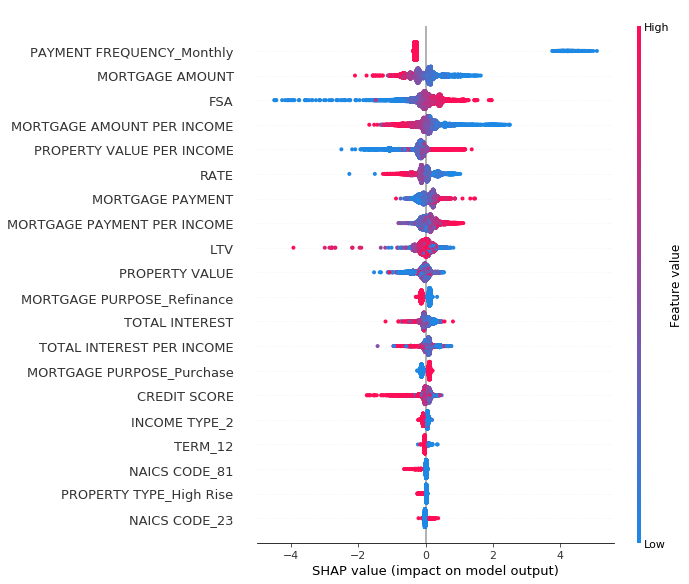

In [202]:
shap.summary_plot(shap_values, train[cnt_cols].iloc[test_index])

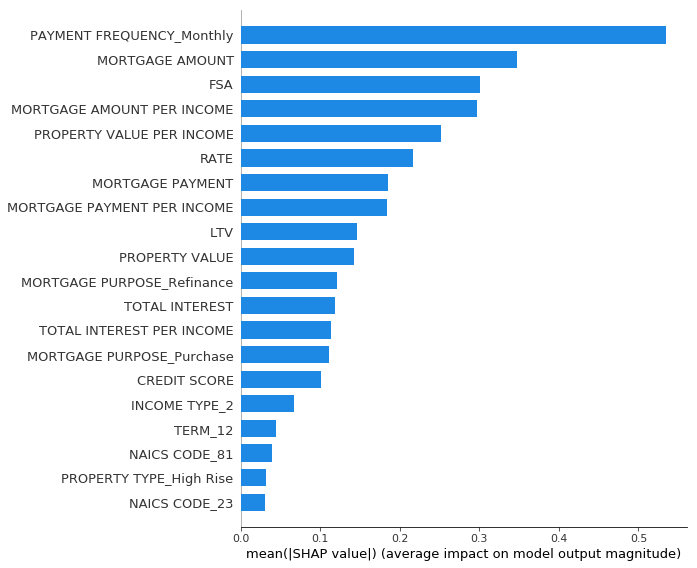

In [203]:
shap.summary_plot(shap_values, train[train_cols].iloc[test_index],plot_type='bar')

In [192]:
train_index

array([    0,     2,     3, ..., 45638, 45639, 45640])

In [193]:
test_index

array([    1,     5,     8, ..., 45631, 45633, 45641])

In [152]:
testpred = rf.predict(test[train_cols])

In [153]:
submission1 = pd.read_csv('../data/CAX_MortgageModeling_SubmissionFormat.csv')
submission1.Result_Predicted = testpred
submission1.head(3)
submission1.Result_Predicted = submission1.Result_Predicted.apply(lambda x: "FUNDED" if x == 1 else "NOT FUNDED")
submission1.Result_Predicted.value_counts(normalize=True)
submission1.to_csv('../submissions/submission1.csv',index=False)

,Unique_ID,Result_Predicted
0,CAX_Test_1,1
1,CAX_Test_2,1
2,CAX_Test_3,1


FUNDED        0.996714
NOT FUNDED    0.003286
Name: Result_Predicted, dtype: float64